In [14]:
import pandas as pd
import numpy as np
import os
import math
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Dense, Dropout, LSTM, BatchNormalization, Bidirectional
from sklearn.utils import shuffle
from sklearn.preprocessing import MinMaxScaler, StandardScaler
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)
# dir_path = './' #local
dir_path = './drive/MyDrive/BAKA/' #colab

In [15]:
#uncomment in colab
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [16]:
files = os.listdir(dir_path + 'Merged')
files

['gestures_train.csv', 'gestures_test.csv']

In [17]:
df_train = pd.read_csv(dir_path + 'Merged/gestures_train.csv')
df_test = pd.read_csv(dir_path + 'Merged/gestures_test.csv')
num_classes = len(df_train.label.unique())
df_train

,label,a1,a2,ab,b1,b2,bc,c1,c2,cd,d1,d2,de,e1,e2,px,py,pz,x0,x1,x2,x3,x4,y0,y1,y2,y3,y4,z0,z1,z2,z3,z4
0,1,171.917694,132.738831,116.083084,168.437363,169.912949,2.744997,95.554222,125.426796,1.433788,98.878227,127.633797,0.321749,98.652611,128.144958,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,1,172.026489,132.672134,116.079544,168.437363,169.912949,0.662870,95.559898,125.403061,2.515430,98.879311,127.635490,0.075647,98.653168,128.149155,-0.004623,0.011925,0.012167,59.335590,-0.010059,0.011242,0.008318,0.011974,41.752968,0.023743,0.069817,0.022484,0.015427,-60.686092,0.031288,-0.019450,0.028371,0.025351
2,1,172.049591,132.658401,116.078300,168.437317,169.913010,1.706766,95.556076,125.403023,1.034447,98.879570,127.635902,0.919123,98.653290,128.150757,-0.000923,0.002502,0.002552,0.001617,-0.002472,-0.004000,0.002121,0.002968,0.004364,0.005936,0.000786,0.005386,0.003067,0.007065,0.008162,0.010556,0.006170,0.006201
3,1,172.071579,132.642776,116.077629,168.437347,169.912949,0.455037,95.549484,125.403069,0.707033,98.879860,127.636314,1.301736,98.654289,128.151947,-0.000923,0.002495,0.002548,0.000597,-0.002464,-0.007114,0.002119,0.003578,0.004433,0.005936,-0.003082,0.005371,0.004326,0.007211,0.008144,0.013555,0.006168,0.004779
4,1,172.092804,132.627594,116.077316,168.437347,169.912933,2.034597,95.544991,125.404495,1.652241,98.880104,127.636703,0.060266,98.655296,128.153198,-0.003822,0.000137,0.001204,-0.002567,-0.008404,-0.008961,-0.001764,-0.000450,0.004295,0.002213,-0.005486,0.002556,0.000992,0.004589,0.001745,0.009327,0.003395,0.003071
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
161795,30,155.428940,174.586319,110.989807,168.322968,170.471313,0.891064,100.356743,141.077988,0.197881,101.467400,141.111938,2.246739,101.672791,141.356110,2.728947,0.310066,-0.266518,2.494905,3.028548,2.748571,2.845219,2.946190,0.300800,0.270683,0.573120,0.451969,0.419716,-0.081818,-0.191807,-0.038231,-0.073334,-0.167938
161796,30,155.546890,175.031281,111.164673,168.517853,170.631866,1.755110,100.357552,141.073151,0.849069,101.470001,141.112167,2.527119,101.694633,141.341766,3.301022,-0.286476,-0.032745,3.242838,2.957266,3.351566,3.343557,3.401852,-0.127975,0.304504,-0.441071,-0.423367,-0.339947,-0.481194,-0.374904,-0.335571,-0.306252,-0.319984
161797,30,155.883240,175.916321,111.659500,168.709732,170.790070,0.870190,100.386345,141.060516,1.251321,101.470955,141.110825,0.360201,101.697769,141.347458,1.644402,-0.627548,0.043282,1.661020,2.078659,1.358609,1.262947,1.341320,-0.388813,-0.135117,-1.058586,-0.907379,-0.691280,-0.401161,0.119175,-0.086823,-0.160332,-0.248985
161798,30,156.244843,176.664246,112.280891,168.823837,170.889343,1.974926,100.382736,141.060654,0.438103,101.471176,141.109833,1.286202,101.696381,141.344925,2.793831,-1.372391,-0.906891,2.365389,2.463518,2.307763,2.223122,2.245644,-0.584534,1.845512,-2.698456,-2.489361,-1.933666,-3.416515,-1.572324,-2.387756,-2.609138,-2.599831


In [18]:
def calculation(df_rows):
    res = {'omega0': [],
           'omega1': [],
           'omega2': [],
           'omega3': [],
           'omega4': [],
           'beta0': [],
           'beta1': [],
           'beta2': [],
           'beta3': [],
           'beta4': [],
           'u0':[],
           'u1':[],
           'u2':[],
           'u3':[],
           'u4':[],
           'u5':[],
           'v0':[],
           'v1':[],
           'v2':[],
           'v3':[],
           'v4':[],
           'v5':[],
           'z0':[],
           'z1':[],
           'z2':[],
           'z3':[],
           'z4':[],
           'z5':[],
           'gamma3': [],
           'gamma2': [],
           'gamma1': []
          }
    for index, row in df_rows.iterrows():
        #intra-finger angles
        res['gamma3'].append(row['ab'])
        res['gamma2'].append(row['bc'])
        res['gamma1'].append(row['cd'])
        
        #finger tip coordinates
        res['u0'].append(row['x0'])
        res['u1'].append(row['x1'])
        res['u2'].append(row['x2'])
        res['u3'].append(row['x3'])
        res['u4'].append(row['x4'])
        
        res['v0'].append(row['y0'])
        res['v1'].append(row['y1'])
        res['v2'].append(row['y2'])
        res['v3'].append(row['y3'])
        res['v4'].append(row['y4'])
        
        res['z0'].append(row['z0'])
        res['z1'].append(row['z1'])
        res['z2'].append(row['z2'])
        res['z3'].append(row['z3'])
        res['z4'].append(row['z4'])
        
        #palm coordinates
        res['u5'].append(row['px'])
        res['v5'].append(row['py'])
        res['z5'].append(row['pz'])
        
        #joint angles omega
        res['omega0'].append(row['e1'])
        res['omega1'].append(row['d1'])
        res['omega2'].append(row['c1'])
        res['omega3'].append(row['b1'])
        res['omega4'].append(row['a1'])
        
        #joint angles beta
        res['beta0'].append(row['e2'])
        res['beta1'].append(row['d2'])
        res['beta2'].append(row['c2'])
        res['beta3'].append(row['b2'])
        res['beta4'].append(row['a2'])
    res = pd.DataFrame(res)
    return res.to_numpy()

In [19]:
def scale_data(data, min_max_scaler):
    for i in range(len(data)):
        data[i] = min_max_scaler.transform(data[i])
    return data

def map_features(df):
    output_df = []
    output_label = []

    for i in range(200,len(df)+1,200):
        if i == 200:
            output_df.append(np.copy(calculation(df[:i])))
            output_label.append(df[:i]['label'][i-1]-1)
        else:
            output_df.append(np.copy(calculation(df[(i-200):i])))
            output_label.append(df[(i-200):i]['label'][i-1]-1)
    return np.array(output_df), np.array(output_label)


    

In [20]:
min_max_scaler = MinMaxScaler(feature_range=(0,1))
x_train, y_train = map_features(df_train)

num_instances, num_time_steps, num_features = x_train.shape
x_train = np.reshape(x_train, newshape=(-1, num_features))
x_train = min_max_scaler.fit_transform(x_train)
x_train = np.reshape(x_train, newshape=(num_instances, num_time_steps, num_features))

x_train, y_train = shuffle(x_train, y_train, random_state=0)

x_test, y_test = map_features(df_test)
num_instances, num_time_steps, num_features = x_test.shape
x_test = np.reshape(x_test, newshape=(-1, num_features))
x_test = min_max_scaler.transform(x_test)
x_test = np.reshape(x_test, newshape=(num_instances, num_time_steps, num_features))

x_test, y_test = shuffle(x_test, y_test, random_state=0)


In [21]:
# x_train = np.delete(x_train, [0,1,2,3,4,5,6,7,8], 0)
# y_train = np.delete(y_train, [0,1,2,3,4,5,6,7,8], 0)
print("x_train.shape: ", x_train.shape)
print("y_train.shiape: ", y_train.shape)
print("x_test.shape: ", x_test.shape)
print("y_test.shape: ", y_test.shape)
# print(y_train)
# print("\n")
# print(y_test)

# print(x_train)
y_train = y_train.astype('int')

# print(y_train)


x_train.shape:  (809, 200, 31)
y_train.shiape:  (809,)
x_test.shape:  (389, 200, 31)
y_test.shape:  (389,)


In [22]:
print(x_train.shape[2])

31


In [23]:
def define_models(drop_rate, number_of_classes):
  models = [Sequential(), Sequential(), Sequential(),Sequential(), Sequential()]
  models[0].add(Bidirectional(LSTM(units=200 ,dtype='float64'),input_shape=x_train.shape[1:],dtype='float64'))
  models[0].add(BatchNormalization())
  models[0].add(Dropout(drop_rate))
  models[0].add(Dense(number_of_classes, activation='softmax',dtype='float64'))

  for i in range(1,len(models)):
    models[i].add(Bidirectional(LSTM(units=200, return_sequences=True ,dtype='float64'),input_shape=x_train.shape[1:],dtype='float64'))
    models[i].add(BatchNormalization())
    models[i].add(Dropout(drop_rate))

    for k in range(0, i-2):
      models[i].add(Bidirectional(LSTM(units=200, return_sequences=True ,dtype='float64') ,dtype='float64'))
      models[i].add(BatchNormalization())
      models[i].add(Dropout(drop_rate))

    models[i].add(Bidirectional(LSTM(units=200 ,dtype='float64') ,dtype='float64'))
    models[i].add(BatchNormalization())
    models[i].add(Dropout(drop_rate))
    
    models[i].add(Dense(number_of_classes, activation='softmax',dtype='float64'))
  
  return models




In [24]:
opt = tf.keras.optimizers.Adam(learning_rate=0.0001, decay=1e-5)
gestures = []
models = {}

for drop_rate in [ 0., 0.1,  0.2,  0.3,  0.4, 0.5,  0.6,  0.7,  0.8,  0.9 ]:
  models[drop_rate] = define_models(drop_rate, num_classes)
  layer = 1
  for m in models[drop_rate]:
    print("***** dropout [", drop_rate, "][",layer,"] *******")
    m.compile(
        loss='sparse_categorical_crossentropy',
        optimizer=opt,
        metrics=['accuracy'],
    )

    gestures.append(m.fit(x = x_train,
              y = y_train,
              epochs=60,
              validation_split=0.1, #split 10% of the trainning set for the validation set,
              batch_size=24,
              shuffle=True
            ))
    m.save(dir_path + 'Models/gestures_' + str(drop_rate) +'_'+str(layer), save_format='tf')
    layer += 1


***** dropout [ 0.0 ][ 1 ] *******
Epoch 1/60
31/31 [==============================] - 5s 84ms/step - loss: 2.9077 - accuracy: 0.2005 - val_loss: 3.2367 - val_accuracy: 0.2099
Epoch 2/60
31/31 [==============================] - 2s 63ms/step - loss: 1.8485 - accuracy: 0.5124 - val_loss: 3.1235 - val_accuracy: 0.3210
Epoch 3/60
31/31 [==============================] - 2s 64ms/step - loss: 1.4220 - accuracy: 0.6607 - val_loss: 2.9926 - val_accuracy: 0.4568
Epoch 4/60
31/31 [==============================] - 2s 64ms/step - loss: 1.1876 - accuracy: 0.7321 - val_loss: 2.8403 - val_accuracy: 0.3827
Epoch 5/60
31/31 [==============================] - 2s 64ms/step - loss: 0.9848 - accuracy: 0.7788 - val_loss: 2.6158 - val_accuracy: 0.4568
Epoch 6/60
31/31 [==============================] - 2s 64ms/step - loss: 0.8811 - accuracy: 0.8008 - val_loss: 2.4219 - val_accuracy: 0.4568
Epoch 7/60
31/31 [==============================] - 2s 65ms/step - loss: 0.7927 - accuracy: 0.8324 - val_loss: 2.1105 -

INFO:tensorflow:Assets written to: ./drive/MyDrive/BAKA/Models/gestures_0.0_1/assets


INFO:tensorflow:Assets written to: ./drive/MyDrive/BAKA/Models/gestures_0.0_1/assets


***** dropout [ 0.0 ][ 2 ] *******
Epoch 1/60
31/31 [==============================] - 10s 173ms/step - loss: 1.4457 - accuracy: 0.6071 - val_loss: 3.1670 - val_accuracy: 0.1111
Epoch 2/60
31/31 [==============================] - 4s 136ms/step - loss: 0.7933 - accuracy: 0.7830 - val_loss: 3.0560 - val_accuracy: 0.2222
Epoch 3/60
31/31 [==============================] - 4s 137ms/step - loss: 0.5832 - accuracy: 0.8489 - val_loss: 2.9476 - val_accuracy: 0.1605
Epoch 4/60
31/31 [==============================] - 4s 138ms/step - loss: 0.5323 - accuracy: 0.8626 - val_loss: 2.7835 - val_accuracy: 0.2840
Epoch 5/60
31/31 [==============================] - 4s 136ms/step - loss: 0.4900 - accuracy: 0.8681 - val_loss: 2.6348 - val_accuracy: 0.3333
Epoch 6/60
31/31 [==============================] - 4s 139ms/step - loss: 0.4736 - accuracy: 0.8654 - val_loss: 2.4350 - val_accuracy: 0.2963
Epoch 7/60
31/31 [==============================] - 4s 137ms/step - loss: 0.4425 - accuracy: 0.8736 - val_loss: 

INFO:tensorflow:Assets written to: ./drive/MyDrive/BAKA/Models/gestures_0.0_2/assets


INFO:tensorflow:Assets written to: ./drive/MyDrive/BAKA/Models/gestures_0.0_2/assets


***** dropout [ 0.0 ][ 3 ] *******
Epoch 1/60
31/31 [==============================] - 11s 204ms/step - loss: 1.5619 - accuracy: 0.5714 - val_loss: 3.2239 - val_accuracy: 0.1111
Epoch 2/60
31/31 [==============================] - 4s 134ms/step - loss: 0.8264 - accuracy: 0.7788 - val_loss: 3.1227 - val_accuracy: 0.0988
Epoch 3/60
31/31 [==============================] - 4s 135ms/step - loss: 0.6598 - accuracy: 0.8324 - val_loss: 3.0140 - val_accuracy: 0.1358
Epoch 4/60
31/31 [==============================] - 4s 134ms/step - loss: 0.5246 - accuracy: 0.8709 - val_loss: 2.8857 - val_accuracy: 0.1975
Epoch 5/60
31/31 [==============================] - 4s 133ms/step - loss: 0.4718 - accuracy: 0.8915 - val_loss: 2.7203 - val_accuracy: 0.1852
Epoch 6/60
31/31 [==============================] - 4s 134ms/step - loss: 0.4200 - accuracy: 0.9038 - val_loss: 2.5386 - val_accuracy: 0.2840
Epoch 7/60
31/31 [==============================] - 4s 135ms/step - loss: 0.4046 - accuracy: 0.8970 - val_loss: 

INFO:tensorflow:Assets written to: ./drive/MyDrive/BAKA/Models/gestures_0.0_3/assets


INFO:tensorflow:Assets written to: ./drive/MyDrive/BAKA/Models/gestures_0.0_3/assets


***** dropout [ 0.0 ][ 4 ] *******
Epoch 1/60
31/31 [==============================] - 16s 259ms/step - loss: 1.6523 - accuracy: 0.5288 - val_loss: 3.2050 - val_accuracy: 0.0864
Epoch 2/60
31/31 [==============================] - 6s 207ms/step - loss: 0.8994 - accuracy: 0.7459 - val_loss: 3.0108 - val_accuracy: 0.2963
Epoch 3/60
31/31 [==============================] - 6s 207ms/step - loss: 0.6652 - accuracy: 0.8228 - val_loss: 2.8524 - val_accuracy: 0.2346
Epoch 4/60
31/31 [==============================] - 6s 208ms/step - loss: 0.5541 - accuracy: 0.8434 - val_loss: 2.5284 - val_accuracy: 0.3333
Epoch 5/60
31/31 [==============================] - 6s 208ms/step - loss: 0.4641 - accuracy: 0.8723 - val_loss: 2.1946 - val_accuracy: 0.4444
Epoch 6/60
31/31 [==============================] - 6s 208ms/step - loss: 0.4874 - accuracy: 0.8681 - val_loss: 1.9142 - val_accuracy: 0.5185
Epoch 7/60
31/31 [==============================] - 6s 207ms/step - loss: 0.4459 - accuracy: 0.8668 - val_loss: 

INFO:tensorflow:Assets written to: ./drive/MyDrive/BAKA/Models/gestures_0.0_4/assets


INFO:tensorflow:Assets written to: ./drive/MyDrive/BAKA/Models/gestures_0.0_4/assets


***** dropout [ 0.0 ][ 5 ] *******
Epoch 1/60
31/31 [==============================] - 21s 346ms/step - loss: 1.5789 - accuracy: 0.5755 - val_loss: 3.1789 - val_accuracy: 0.1111
Epoch 2/60
31/31 [==============================] - 9s 281ms/step - loss: 1.0005 - accuracy: 0.7184 - val_loss: 2.9232 - val_accuracy: 0.3333
Epoch 3/60
31/31 [==============================] - 9s 282ms/step - loss: 0.6991 - accuracy: 0.8104 - val_loss: 2.6108 - val_accuracy: 0.4321
Epoch 4/60
31/31 [==============================] - 9s 280ms/step - loss: 0.5433 - accuracy: 0.8503 - val_loss: 2.1643 - val_accuracy: 0.4815
Epoch 5/60
31/31 [==============================] - 9s 282ms/step - loss: 0.5514 - accuracy: 0.8420 - val_loss: 1.8466 - val_accuracy: 0.5432
Epoch 6/60
31/31 [==============================] - 9s 282ms/step - loss: 0.4584 - accuracy: 0.8695 - val_loss: 1.5455 - val_accuracy: 0.6420
Epoch 7/60
31/31 [==============================] - 9s 283ms/step - loss: 0.4416 - accuracy: 0.8723 - val_loss: 

INFO:tensorflow:Assets written to: ./drive/MyDrive/BAKA/Models/gestures_0.0_5/assets


INFO:tensorflow:Assets written to: ./drive/MyDrive/BAKA/Models/gestures_0.0_5/assets


***** dropout [ 0.1 ][ 1 ] *******
Epoch 1/60
31/31 [==============================] - 5s 85ms/step - loss: 1.9680 - accuracy: 0.4451 - val_loss: 2.9622 - val_accuracy: 0.2716
Epoch 2/60
31/31 [==============================] - 2s 65ms/step - loss: 0.9673 - accuracy: 0.7280 - val_loss: 2.7850 - val_accuracy: 0.4198
Epoch 3/60
31/31 [==============================] - 2s 65ms/step - loss: 0.8159 - accuracy: 0.7802 - val_loss: 2.6418 - val_accuracy: 0.5309
Epoch 4/60
31/31 [==============================] - 2s 65ms/step - loss: 0.7348 - accuracy: 0.8269 - val_loss: 2.5007 - val_accuracy: 0.6049
Epoch 5/60
31/31 [==============================] - 2s 65ms/step - loss: 0.6396 - accuracy: 0.8544 - val_loss: 2.2685 - val_accuracy: 0.6790
Epoch 6/60
31/31 [==============================] - 2s 65ms/step - loss: 0.6318 - accuracy: 0.8585 - val_loss: 2.1893 - val_accuracy: 0.5556
Epoch 7/60
31/31 [==============================] - 2s 65ms/step - loss: 0.6167 - accuracy: 0.8723 - val_loss: 1.8961 -

INFO:tensorflow:Assets written to: ./drive/MyDrive/BAKA/Models/gestures_0.1_1/assets


INFO:tensorflow:Assets written to: ./drive/MyDrive/BAKA/Models/gestures_0.1_1/assets


***** dropout [ 0.1 ][ 2 ] *******
Epoch 1/60
31/31 [==============================] - 10s 174ms/step - loss: 1.7149 - accuracy: 0.5536 - val_loss: 3.1920 - val_accuracy: 0.1605
Epoch 2/60
31/31 [==============================] - 4s 137ms/step - loss: 0.9119 - accuracy: 0.7555 - val_loss: 3.0605 - val_accuracy: 0.3827
Epoch 3/60
31/31 [==============================] - 4s 137ms/step - loss: 0.7003 - accuracy: 0.8091 - val_loss: 2.9256 - val_accuracy: 0.4074
Epoch 4/60
31/31 [==============================] - 4s 138ms/step - loss: 0.6581 - accuracy: 0.8214 - val_loss: 2.7563 - val_accuracy: 0.5185
Epoch 5/60
31/31 [==============================] - 4s 137ms/step - loss: 0.5725 - accuracy: 0.8558 - val_loss: 2.5636 - val_accuracy: 0.5679
Epoch 6/60
31/31 [==============================] - 4s 136ms/step - loss: 0.5032 - accuracy: 0.8681 - val_loss: 2.3108 - val_accuracy: 0.6790
Epoch 7/60
31/31 [==============================] - 4s 137ms/step - loss: 0.4855 - accuracy: 0.8709 - val_loss: 

INFO:tensorflow:Assets written to: ./drive/MyDrive/BAKA/Models/gestures_0.1_2/assets


INFO:tensorflow:Assets written to: ./drive/MyDrive/BAKA/Models/gestures_0.1_2/assets


***** dropout [ 0.1 ][ 3 ] *******
Epoch 1/60
31/31 [==============================] - 10s 175ms/step - loss: 1.6527 - accuracy: 0.5385 - val_loss: 3.1420 - val_accuracy: 0.3210
Epoch 2/60
31/31 [==============================] - 4s 138ms/step - loss: 0.9748 - accuracy: 0.7198 - val_loss: 3.0120 - val_accuracy: 0.3457
Epoch 3/60
31/31 [==============================] - 4s 138ms/step - loss: 0.6992 - accuracy: 0.8118 - val_loss: 2.8798 - val_accuracy: 0.3827
Epoch 4/60
31/31 [==============================] - 4s 137ms/step - loss: 0.6642 - accuracy: 0.8187 - val_loss: 2.7039 - val_accuracy: 0.4198
Epoch 5/60
31/31 [==============================] - 4s 137ms/step - loss: 0.5659 - accuracy: 0.8475 - val_loss: 2.5318 - val_accuracy: 0.5556
Epoch 6/60
31/31 [==============================] - 4s 138ms/step - loss: 0.4887 - accuracy: 0.8709 - val_loss: 2.2876 - val_accuracy: 0.6049
Epoch 7/60
31/31 [==============================] - 4s 138ms/step - loss: 0.4417 - accuracy: 0.8874 - val_loss: 

INFO:tensorflow:Assets written to: ./drive/MyDrive/BAKA/Models/gestures_0.1_3/assets


INFO:tensorflow:Assets written to: ./drive/MyDrive/BAKA/Models/gestures_0.1_3/assets


***** dropout [ 0.1 ][ 4 ] *******
Epoch 1/60
31/31 [==============================] - 15s 262ms/step - loss: 1.6582 - accuracy: 0.5426 - val_loss: 3.2058 - val_accuracy: 0.0988
Epoch 2/60
31/31 [==============================] - 7s 210ms/step - loss: 1.0420 - accuracy: 0.7019 - val_loss: 3.0150 - val_accuracy: 0.1605
Epoch 3/60
31/31 [==============================] - 7s 212ms/step - loss: 0.7518 - accuracy: 0.8022 - val_loss: 2.8861 - val_accuracy: 0.1358
Epoch 4/60
31/31 [==============================] - 7s 211ms/step - loss: 0.6318 - accuracy: 0.8310 - val_loss: 2.6162 - val_accuracy: 0.3457
Epoch 5/60
31/31 [==============================] - 7s 211ms/step - loss: 0.5399 - accuracy: 0.8558 - val_loss: 2.2975 - val_accuracy: 0.5062
Epoch 6/60
31/31 [==============================] - 7s 211ms/step - loss: 0.5394 - accuracy: 0.8489 - val_loss: 2.1104 - val_accuracy: 0.4568
Epoch 7/60
31/31 [==============================] - 7s 212ms/step - loss: 0.4987 - accuracy: 0.8558 - val_loss: 

INFO:tensorflow:Assets written to: ./drive/MyDrive/BAKA/Models/gestures_0.1_4/assets


INFO:tensorflow:Assets written to: ./drive/MyDrive/BAKA/Models/gestures_0.1_4/assets


***** dropout [ 0.1 ][ 5 ] *******
Epoch 1/60
31/31 [==============================] - 20s 353ms/step - loss: 1.6939 - accuracy: 0.5302 - val_loss: 3.1552 - val_accuracy: 0.2222
Epoch 2/60
31/31 [==============================] - 9s 284ms/step - loss: 0.9646 - accuracy: 0.7129 - val_loss: 3.0101 - val_accuracy: 0.1605
Epoch 3/60
31/31 [==============================] - 9s 282ms/step - loss: 0.7650 - accuracy: 0.7967 - val_loss: 2.7144 - val_accuracy: 0.3086
Epoch 4/60
31/31 [==============================] - 9s 284ms/step - loss: 0.6147 - accuracy: 0.8201 - val_loss: 2.4732 - val_accuracy: 0.3210
Epoch 5/60
31/31 [==============================] - 9s 283ms/step - loss: 0.5709 - accuracy: 0.8242 - val_loss: 2.1543 - val_accuracy: 0.4568
Epoch 6/60
31/31 [==============================] - 9s 282ms/step - loss: 0.6157 - accuracy: 0.8297 - val_loss: 1.8000 - val_accuracy: 0.5802
Epoch 7/60
31/31 [==============================] - 9s 284ms/step - loss: 0.5330 - accuracy: 0.8475 - val_loss: 

INFO:tensorflow:Assets written to: ./drive/MyDrive/BAKA/Models/gestures_0.1_5/assets


INFO:tensorflow:Assets written to: ./drive/MyDrive/BAKA/Models/gestures_0.1_5/assets


***** dropout [ 0.2 ][ 1 ] *******
Epoch 1/60
31/31 [==============================] - 5s 84ms/step - loss: 2.0744 - accuracy: 0.4011 - val_loss: 3.0124 - val_accuracy: 0.1852
Epoch 2/60
31/31 [==============================] - 2s 65ms/step - loss: 1.0947 - accuracy: 0.6896 - val_loss: 2.8810 - val_accuracy: 0.2593
Epoch 3/60
31/31 [==============================] - 2s 65ms/step - loss: 0.9018 - accuracy: 0.7637 - val_loss: 2.7516 - val_accuracy: 0.2963
Epoch 4/60
31/31 [==============================] - 2s 65ms/step - loss: 0.7708 - accuracy: 0.8049 - val_loss: 2.5173 - val_accuracy: 0.5556
Epoch 5/60
31/31 [==============================] - 2s 65ms/step - loss: 0.7428 - accuracy: 0.8352 - val_loss: 2.3342 - val_accuracy: 0.5802
Epoch 6/60
31/31 [==============================] - 2s 65ms/step - loss: 0.6986 - accuracy: 0.8420 - val_loss: 2.1508 - val_accuracy: 0.6790
Epoch 7/60
31/31 [==============================] - 2s 65ms/step - loss: 0.6820 - accuracy: 0.8434 - val_loss: 1.9186 -

INFO:tensorflow:Assets written to: ./drive/MyDrive/BAKA/Models/gestures_0.2_1/assets


INFO:tensorflow:Assets written to: ./drive/MyDrive/BAKA/Models/gestures_0.2_1/assets


***** dropout [ 0.2 ][ 2 ] *******
Epoch 1/60
31/31 [==============================] - 10s 172ms/step - loss: 1.9879 - accuracy: 0.4670 - val_loss: 3.1286 - val_accuracy: 0.1111
Epoch 2/60
31/31 [==============================] - 4s 136ms/step - loss: 1.0008 - accuracy: 0.7129 - val_loss: 3.0026 - val_accuracy: 0.1111
Epoch 3/60
31/31 [==============================] - 4s 136ms/step - loss: 0.8231 - accuracy: 0.7761 - val_loss: 2.8435 - val_accuracy: 0.2469
Epoch 4/60
31/31 [==============================] - 4s 135ms/step - loss: 0.7314 - accuracy: 0.7940 - val_loss: 2.6722 - val_accuracy: 0.3704
Epoch 5/60
31/31 [==============================] - 4s 135ms/step - loss: 0.5954 - accuracy: 0.8407 - val_loss: 2.4672 - val_accuracy: 0.4444
Epoch 6/60
31/31 [==============================] - 4s 136ms/step - loss: 0.5727 - accuracy: 0.8516 - val_loss: 2.2416 - val_accuracy: 0.5926
Epoch 7/60
31/31 [==============================] - 4s 136ms/step - loss: 0.5136 - accuracy: 0.8736 - val_loss: 

INFO:tensorflow:Assets written to: ./drive/MyDrive/BAKA/Models/gestures_0.2_2/assets


INFO:tensorflow:Assets written to: ./drive/MyDrive/BAKA/Models/gestures_0.2_2/assets


***** dropout [ 0.2 ][ 3 ] *******
Epoch 1/60
31/31 [==============================] - 10s 172ms/step - loss: 1.8814 - accuracy: 0.4533 - val_loss: 3.0919 - val_accuracy: 0.2593
Epoch 2/60
31/31 [==============================] - 4s 136ms/step - loss: 1.0035 - accuracy: 0.7184 - val_loss: 2.9736 - val_accuracy: 0.2716
Epoch 3/60
31/31 [==============================] - 4s 136ms/step - loss: 0.8213 - accuracy: 0.7527 - val_loss: 2.8602 - val_accuracy: 0.3457
Epoch 4/60
31/31 [==============================] - 4s 136ms/step - loss: 0.6312 - accuracy: 0.8448 - val_loss: 2.7022 - val_accuracy: 0.4444
Epoch 5/60
31/31 [==============================] - 4s 135ms/step - loss: 0.5806 - accuracy: 0.8448 - val_loss: 2.4708 - val_accuracy: 0.5556
Epoch 6/60
31/31 [==============================] - 4s 135ms/step - loss: 0.5486 - accuracy: 0.8544 - val_loss: 2.2143 - val_accuracy: 0.6667
Epoch 7/60
31/31 [==============================] - 4s 137ms/step - loss: 0.4969 - accuracy: 0.8832 - val_loss: 

INFO:tensorflow:Assets written to: ./drive/MyDrive/BAKA/Models/gestures_0.2_3/assets


INFO:tensorflow:Assets written to: ./drive/MyDrive/BAKA/Models/gestures_0.2_3/assets


***** dropout [ 0.2 ][ 4 ] *******
Epoch 1/60
31/31 [==============================] - 15s 261ms/step - loss: 1.9330 - accuracy: 0.4560 - val_loss: 3.1252 - val_accuracy: 0.2593
Epoch 2/60
31/31 [==============================] - 6s 209ms/step - loss: 1.0684 - accuracy: 0.7005 - val_loss: 2.9072 - val_accuracy: 0.4074
Epoch 3/60
31/31 [==============================] - 6s 209ms/step - loss: 0.7831 - accuracy: 0.7679 - val_loss: 2.7010 - val_accuracy: 0.3951
Epoch 4/60
31/31 [==============================] - 6s 209ms/step - loss: 0.6787 - accuracy: 0.8187 - val_loss: 2.4423 - val_accuracy: 0.5926
Epoch 5/60
31/31 [==============================] - 6s 209ms/step - loss: 0.6097 - accuracy: 0.8365 - val_loss: 2.1445 - val_accuracy: 0.5802
Epoch 6/60
31/31 [==============================] - 6s 209ms/step - loss: 0.5475 - accuracy: 0.8365 - val_loss: 1.7964 - val_accuracy: 0.6914
Epoch 7/60
31/31 [==============================] - 6s 210ms/step - loss: 0.5263 - accuracy: 0.8530 - val_loss: 

INFO:tensorflow:Assets written to: ./drive/MyDrive/BAKA/Models/gestures_0.2_4/assets


INFO:tensorflow:Assets written to: ./drive/MyDrive/BAKA/Models/gestures_0.2_4/assets


***** dropout [ 0.2 ][ 5 ] *******
Epoch 1/60
31/31 [==============================] - 20s 349ms/step - loss: 1.9019 - accuracy: 0.4808 - val_loss: 3.1815 - val_accuracy: 0.1728
Epoch 2/60
31/31 [==============================] - 9s 283ms/step - loss: 1.0349 - accuracy: 0.7047 - val_loss: 3.0029 - val_accuracy: 0.1975
Epoch 3/60
31/31 [==============================] - 9s 284ms/step - loss: 0.9016 - accuracy: 0.7390 - val_loss: 2.7574 - val_accuracy: 0.3704
Epoch 4/60
31/31 [==============================] - 9s 283ms/step - loss: 0.7216 - accuracy: 0.8022 - val_loss: 2.3219 - val_accuracy: 0.4321
Epoch 5/60
31/31 [==============================] - 9s 283ms/step - loss: 0.6391 - accuracy: 0.8255 - val_loss: 2.0116 - val_accuracy: 0.5062
Epoch 6/60
31/31 [==============================] - 9s 283ms/step - loss: 0.6198 - accuracy: 0.8324 - val_loss: 1.5897 - val_accuracy: 0.5802
Epoch 7/60
31/31 [==============================] - 9s 282ms/step - loss: 0.5918 - accuracy: 0.8338 - val_loss: 

INFO:tensorflow:Assets written to: ./drive/MyDrive/BAKA/Models/gestures_0.2_5/assets


INFO:tensorflow:Assets written to: ./drive/MyDrive/BAKA/Models/gestures_0.2_5/assets


***** dropout [ 0.3 ][ 1 ] *******
Epoch 1/60
31/31 [==============================] - 5s 85ms/step - loss: 2.3065 - accuracy: 0.3503 - val_loss: 3.0841 - val_accuracy: 0.1358
Epoch 2/60
31/31 [==============================] - 2s 65ms/step - loss: 1.2440 - accuracy: 0.6497 - val_loss: 2.9306 - val_accuracy: 0.3704
Epoch 3/60
31/31 [==============================] - 2s 64ms/step - loss: 0.9665 - accuracy: 0.7459 - val_loss: 2.8135 - val_accuracy: 0.3580
Epoch 4/60
31/31 [==============================] - 2s 65ms/step - loss: 0.8795 - accuracy: 0.7706 - val_loss: 2.6586 - val_accuracy: 0.3457
Epoch 5/60
31/31 [==============================] - 2s 65ms/step - loss: 0.8369 - accuracy: 0.7788 - val_loss: 2.3752 - val_accuracy: 0.6790
Epoch 6/60
31/31 [==============================] - 2s 65ms/step - loss: 0.7620 - accuracy: 0.8104 - val_loss: 2.2355 - val_accuracy: 0.4938
Epoch 7/60
31/31 [==============================] - 2s 65ms/step - loss: 0.6998 - accuracy: 0.8352 - val_loss: 1.9757 -

INFO:tensorflow:Assets written to: ./drive/MyDrive/BAKA/Models/gestures_0.3_1/assets


INFO:tensorflow:Assets written to: ./drive/MyDrive/BAKA/Models/gestures_0.3_1/assets


***** dropout [ 0.3 ][ 2 ] *******
Epoch 1/60
31/31 [==============================] - 10s 173ms/step - loss: 2.1558 - accuracy: 0.3929 - val_loss: 3.1458 - val_accuracy: 0.1728
Epoch 2/60
31/31 [==============================] - 4s 136ms/step - loss: 1.1824 - accuracy: 0.6360 - val_loss: 3.0012 - val_accuracy: 0.2840
Epoch 3/60
31/31 [==============================] - 4s 137ms/step - loss: 0.9783 - accuracy: 0.7157 - val_loss: 2.8683 - val_accuracy: 0.2840
Epoch 4/60
31/31 [==============================] - 4s 135ms/step - loss: 0.7840 - accuracy: 0.7788 - val_loss: 2.6846 - val_accuracy: 0.4938
Epoch 5/60
31/31 [==============================] - 4s 135ms/step - loss: 0.7311 - accuracy: 0.7967 - val_loss: 2.4842 - val_accuracy: 0.4938
Epoch 6/60
31/31 [==============================] - 4s 136ms/step - loss: 0.6544 - accuracy: 0.8434 - val_loss: 2.2590 - val_accuracy: 0.6420
Epoch 7/60
31/31 [==============================] - 4s 137ms/step - loss: 0.6120 - accuracy: 0.8365 - val_loss: 

INFO:tensorflow:Assets written to: ./drive/MyDrive/BAKA/Models/gestures_0.3_2/assets


INFO:tensorflow:Assets written to: ./drive/MyDrive/BAKA/Models/gestures_0.3_2/assets


***** dropout [ 0.3 ][ 3 ] *******
Epoch 1/60
31/31 [==============================] - 10s 172ms/step - loss: 2.3757 - accuracy: 0.3695 - val_loss: 3.1339 - val_accuracy: 0.2222
Epoch 2/60
31/31 [==============================] - 4s 136ms/step - loss: 1.2697 - accuracy: 0.6360 - val_loss: 2.9784 - val_accuracy: 0.3086
Epoch 3/60
31/31 [==============================] - 4s 136ms/step - loss: 0.9601 - accuracy: 0.7266 - val_loss: 2.8348 - val_accuracy: 0.4321
Epoch 4/60
31/31 [==============================] - 4s 136ms/step - loss: 0.7938 - accuracy: 0.7857 - val_loss: 2.6370 - val_accuracy: 0.4938
Epoch 5/60
31/31 [==============================] - 4s 137ms/step - loss: 0.6660 - accuracy: 0.8228 - val_loss: 2.4457 - val_accuracy: 0.5802
Epoch 6/60
31/31 [==============================] - 4s 136ms/step - loss: 0.6675 - accuracy: 0.8393 - val_loss: 2.1938 - val_accuracy: 0.6173
Epoch 7/60
31/31 [==============================] - 4s 136ms/step - loss: 0.6088 - accuracy: 0.8448 - val_loss: 

INFO:tensorflow:Assets written to: ./drive/MyDrive/BAKA/Models/gestures_0.3_3/assets


INFO:tensorflow:Assets written to: ./drive/MyDrive/BAKA/Models/gestures_0.3_3/assets


***** dropout [ 0.3 ][ 4 ] *******
Epoch 1/60
31/31 [==============================] - 15s 261ms/step - loss: 2.0942 - accuracy: 0.4492 - val_loss: 3.1693 - val_accuracy: 0.1975
Epoch 2/60
31/31 [==============================] - 7s 210ms/step - loss: 1.1371 - accuracy: 0.6497 - val_loss: 2.9599 - val_accuracy: 0.2963
Epoch 3/60
31/31 [==============================] - 7s 210ms/step - loss: 0.9316 - accuracy: 0.7115 - val_loss: 2.7158 - val_accuracy: 0.5062
Epoch 4/60
31/31 [==============================] - 6s 209ms/step - loss: 0.8076 - accuracy: 0.7816 - val_loss: 2.4295 - val_accuracy: 0.5679
Epoch 5/60
31/31 [==============================] - 6s 209ms/step - loss: 0.7733 - accuracy: 0.7857 - val_loss: 2.1075 - val_accuracy: 0.5926
Epoch 6/60
31/31 [==============================] - 6s 209ms/step - loss: 0.7143 - accuracy: 0.8022 - val_loss: 1.7969 - val_accuracy: 0.6667
Epoch 7/60
31/31 [==============================] - 6s 210ms/step - loss: 0.5649 - accuracy: 0.8544 - val_loss: 

INFO:tensorflow:Assets written to: ./drive/MyDrive/BAKA/Models/gestures_0.3_4/assets


INFO:tensorflow:Assets written to: ./drive/MyDrive/BAKA/Models/gestures_0.3_4/assets


***** dropout [ 0.3 ][ 5 ] *******
Epoch 1/60
31/31 [==============================] - 20s 350ms/step - loss: 2.1139 - accuracy: 0.4203 - val_loss: 3.1430 - val_accuracy: 0.1481
Epoch 2/60
31/31 [==============================] - 9s 282ms/step - loss: 1.1769 - accuracy: 0.6566 - val_loss: 2.9391 - val_accuracy: 0.2469
Epoch 3/60
31/31 [==============================] - 9s 282ms/step - loss: 0.9427 - accuracy: 0.7266 - val_loss: 2.6590 - val_accuracy: 0.2716
Epoch 4/60
31/31 [==============================] - 9s 282ms/step - loss: 0.8182 - accuracy: 0.7706 - val_loss: 2.2386 - val_accuracy: 0.4691
Epoch 5/60
31/31 [==============================] - 9s 282ms/step - loss: 0.7478 - accuracy: 0.7816 - val_loss: 1.8387 - val_accuracy: 0.5802
Epoch 6/60
31/31 [==============================] - 9s 282ms/step - loss: 0.5986 - accuracy: 0.8407 - val_loss: 1.4665 - val_accuracy: 0.6173
Epoch 7/60
31/31 [==============================] - 9s 283ms/step - loss: 0.6305 - accuracy: 0.8269 - val_loss: 

INFO:tensorflow:Assets written to: ./drive/MyDrive/BAKA/Models/gestures_0.3_5/assets


INFO:tensorflow:Assets written to: ./drive/MyDrive/BAKA/Models/gestures_0.3_5/assets


***** dropout [ 0.4 ][ 1 ] *******
Epoch 1/60
31/31 [==============================] - 5s 86ms/step - loss: 2.2979 - accuracy: 0.3269 - val_loss: 3.0917 - val_accuracy: 0.1481
Epoch 2/60
31/31 [==============================] - 2s 66ms/step - loss: 1.3123 - accuracy: 0.6195 - val_loss: 2.9408 - val_accuracy: 0.4074
Epoch 3/60
31/31 [==============================] - 2s 65ms/step - loss: 1.0618 - accuracy: 0.7047 - val_loss: 2.8051 - val_accuracy: 0.2840
Epoch 4/60
31/31 [==============================] - 2s 66ms/step - loss: 1.0115 - accuracy: 0.7088 - val_loss: 2.6413 - val_accuracy: 0.5309
Epoch 5/60
31/31 [==============================] - 2s 65ms/step - loss: 0.8881 - accuracy: 0.7610 - val_loss: 2.4557 - val_accuracy: 0.5926
Epoch 6/60
31/31 [==============================] - 2s 65ms/step - loss: 0.8312 - accuracy: 0.7857 - val_loss: 2.2327 - val_accuracy: 0.5556
Epoch 7/60
31/31 [==============================] - 2s 66ms/step - loss: 0.7736 - accuracy: 0.8063 - val_loss: 2.0931 -

INFO:tensorflow:Assets written to: ./drive/MyDrive/BAKA/Models/gestures_0.4_1/assets


INFO:tensorflow:Assets written to: ./drive/MyDrive/BAKA/Models/gestures_0.4_1/assets


***** dropout [ 0.4 ][ 2 ] *******
Epoch 1/60
31/31 [==============================] - 10s 172ms/step - loss: 2.5088 - accuracy: 0.3613 - val_loss: 3.1303 - val_accuracy: 0.3210
Epoch 2/60
31/31 [==============================] - 4s 138ms/step - loss: 1.3630 - accuracy: 0.5838 - val_loss: 2.9939 - val_accuracy: 0.3704
Epoch 3/60
31/31 [==============================] - 4s 136ms/step - loss: 1.0449 - accuracy: 0.6868 - val_loss: 2.8177 - val_accuracy: 0.4444
Epoch 4/60
31/31 [==============================] - 4s 136ms/step - loss: 0.9302 - accuracy: 0.7404 - val_loss: 2.6578 - val_accuracy: 0.5062
Epoch 5/60
31/31 [==============================] - 4s 136ms/step - loss: 0.8162 - accuracy: 0.7967 - val_loss: 2.4196 - val_accuracy: 0.5309
Epoch 6/60
31/31 [==============================] - 4s 136ms/step - loss: 0.6994 - accuracy: 0.8132 - val_loss: 2.1761 - val_accuracy: 0.6420
Epoch 7/60
31/31 [==============================] - 4s 136ms/step - loss: 0.6711 - accuracy: 0.8159 - val_loss: 

INFO:tensorflow:Assets written to: ./drive/MyDrive/BAKA/Models/gestures_0.4_2/assets


INFO:tensorflow:Assets written to: ./drive/MyDrive/BAKA/Models/gestures_0.4_2/assets


***** dropout [ 0.4 ][ 3 ] *******
Epoch 1/60
31/31 [==============================] - 10s 172ms/step - loss: 2.7010 - accuracy: 0.3379 - val_loss: 3.1529 - val_accuracy: 0.1481
Epoch 2/60
31/31 [==============================] - 4s 136ms/step - loss: 1.4329 - accuracy: 0.5783 - val_loss: 3.0394 - val_accuracy: 0.2716
Epoch 3/60
31/31 [==============================] - 4s 137ms/step - loss: 1.0724 - accuracy: 0.6854 - val_loss: 2.8775 - val_accuracy: 0.4074
Epoch 4/60
31/31 [==============================] - 4s 136ms/step - loss: 0.9860 - accuracy: 0.7115 - val_loss: 2.7324 - val_accuracy: 0.3827
Epoch 5/60
31/31 [==============================] - 4s 136ms/step - loss: 0.8680 - accuracy: 0.7431 - val_loss: 2.5123 - val_accuracy: 0.5062
Epoch 6/60
31/31 [==============================] - 4s 135ms/step - loss: 0.7821 - accuracy: 0.7720 - val_loss: 2.2854 - val_accuracy: 0.5679
Epoch 7/60
31/31 [==============================] - 4s 136ms/step - loss: 0.7552 - accuracy: 0.7816 - val_loss: 

INFO:tensorflow:Assets written to: ./drive/MyDrive/BAKA/Models/gestures_0.4_3/assets


INFO:tensorflow:Assets written to: ./drive/MyDrive/BAKA/Models/gestures_0.4_3/assets


***** dropout [ 0.4 ][ 4 ] *******
Epoch 1/60
31/31 [==============================] - 18s 262ms/step - loss: 2.4496 - accuracy: 0.3613 - val_loss: 3.1499 - val_accuracy: 0.2222
Epoch 2/60
31/31 [==============================] - 7s 211ms/step - loss: 1.3325 - accuracy: 0.6181 - val_loss: 2.9466 - val_accuracy: 0.2716
Epoch 3/60
31/31 [==============================] - 7s 211ms/step - loss: 1.0581 - accuracy: 0.7060 - val_loss: 2.7219 - val_accuracy: 0.3951
Epoch 4/60
31/31 [==============================] - 7s 211ms/step - loss: 0.9137 - accuracy: 0.7431 - val_loss: 2.4140 - val_accuracy: 0.4938
Epoch 5/60
31/31 [==============================] - 6s 209ms/step - loss: 0.7716 - accuracy: 0.7665 - val_loss: 2.0981 - val_accuracy: 0.5556
Epoch 6/60
31/31 [==============================] - 6s 210ms/step - loss: 0.7761 - accuracy: 0.7830 - val_loss: 1.7909 - val_accuracy: 0.5432
Epoch 7/60
31/31 [==============================] - 6s 209ms/step - loss: 0.7436 - accuracy: 0.7885 - val_loss: 

INFO:tensorflow:Assets written to: ./drive/MyDrive/BAKA/Models/gestures_0.4_4/assets


INFO:tensorflow:Assets written to: ./drive/MyDrive/BAKA/Models/gestures_0.4_4/assets


***** dropout [ 0.4 ][ 5 ] *******
Epoch 1/60
31/31 [==============================] - 23s 349ms/step - loss: 2.4917 - accuracy: 0.3613 - val_loss: 3.1653 - val_accuracy: 0.1605
Epoch 2/60
31/31 [==============================] - 9s 283ms/step - loss: 1.4007 - accuracy: 0.6085 - val_loss: 2.9172 - val_accuracy: 0.2593
Epoch 3/60
31/31 [==============================] - 9s 283ms/step - loss: 1.0515 - accuracy: 0.7088 - val_loss: 2.6216 - val_accuracy: 0.3333
Epoch 4/60
31/31 [==============================] - 9s 284ms/step - loss: 0.9165 - accuracy: 0.7390 - val_loss: 2.1991 - val_accuracy: 0.4321
Epoch 5/60
31/31 [==============================] - 9s 283ms/step - loss: 0.9388 - accuracy: 0.7404 - val_loss: 1.7687 - val_accuracy: 0.5309
Epoch 6/60
31/31 [==============================] - 9s 284ms/step - loss: 0.7102 - accuracy: 0.8036 - val_loss: 1.4799 - val_accuracy: 0.6296
Epoch 7/60
31/31 [==============================] - 9s 284ms/step - loss: 0.7495 - accuracy: 0.7898 - val_loss: 

INFO:tensorflow:Assets written to: ./drive/MyDrive/BAKA/Models/gestures_0.4_5/assets


INFO:tensorflow:Assets written to: ./drive/MyDrive/BAKA/Models/gestures_0.4_5/assets


***** dropout [ 0.5 ][ 1 ] *******
Epoch 1/60
31/31 [==============================] - 5s 84ms/step - loss: 2.7499 - accuracy: 0.2541 - val_loss: 3.0881 - val_accuracy: 0.1481
Epoch 2/60
31/31 [==============================] - 2s 65ms/step - loss: 1.5222 - accuracy: 0.5536 - val_loss: 2.9800 - val_accuracy: 0.1358
Epoch 3/60
31/31 [==============================] - 2s 65ms/step - loss: 1.2145 - accuracy: 0.6566 - val_loss: 2.8062 - val_accuracy: 0.3333
Epoch 4/60
31/31 [==============================] - 2s 66ms/step - loss: 1.0889 - accuracy: 0.6868 - val_loss: 2.6883 - val_accuracy: 0.2716
Epoch 5/60
31/31 [==============================] - 2s 65ms/step - loss: 1.0238 - accuracy: 0.7102 - val_loss: 2.4470 - val_accuracy: 0.6296
Epoch 6/60
31/31 [==============================] - 2s 66ms/step - loss: 0.9406 - accuracy: 0.7321 - val_loss: 2.2265 - val_accuracy: 0.6667
Epoch 7/60
31/31 [==============================] - 2s 65ms/step - loss: 0.8953 - accuracy: 0.7555 - val_loss: 2.0404 -

INFO:tensorflow:Assets written to: ./drive/MyDrive/BAKA/Models/gestures_0.5_1/assets


INFO:tensorflow:Assets written to: ./drive/MyDrive/BAKA/Models/gestures_0.5_1/assets


***** dropout [ 0.5 ][ 2 ] *******
Epoch 1/60
31/31 [==============================] - 10s 175ms/step - loss: 2.9713 - accuracy: 0.2706 - val_loss: 3.1543 - val_accuracy: 0.1358
Epoch 2/60
31/31 [==============================] - 4s 137ms/step - loss: 1.7111 - accuracy: 0.5206 - val_loss: 2.9637 - val_accuracy: 0.2963
Epoch 3/60
31/31 [==============================] - 4s 137ms/step - loss: 1.4291 - accuracy: 0.5783 - val_loss: 2.7902 - val_accuracy: 0.3333
Epoch 4/60
31/31 [==============================] - 4s 137ms/step - loss: 1.2223 - accuracy: 0.6415 - val_loss: 2.6000 - val_accuracy: 0.4691
Epoch 5/60
31/31 [==============================] - 4s 137ms/step - loss: 1.1060 - accuracy: 0.7033 - val_loss: 2.3513 - val_accuracy: 0.5185
Epoch 6/60
31/31 [==============================] - 4s 137ms/step - loss: 0.9358 - accuracy: 0.7335 - val_loss: 2.0871 - val_accuracy: 0.5309
Epoch 7/60
31/31 [==============================] - 4s 137ms/step - loss: 0.9009 - accuracy: 0.7445 - val_loss: 

INFO:tensorflow:Assets written to: ./drive/MyDrive/BAKA/Models/gestures_0.5_2/assets


INFO:tensorflow:Assets written to: ./drive/MyDrive/BAKA/Models/gestures_0.5_2/assets


***** dropout [ 0.5 ][ 3 ] *******
Epoch 1/60
31/31 [==============================] - 10s 172ms/step - loss: 3.1919 - accuracy: 0.2060 - val_loss: 3.1624 - val_accuracy: 0.1481
Epoch 2/60
31/31 [==============================] - 4s 136ms/step - loss: 1.7821 - accuracy: 0.4780 - val_loss: 3.0059 - val_accuracy: 0.2963
Epoch 3/60
31/31 [==============================] - 4s 136ms/step - loss: 1.3860 - accuracy: 0.5865 - val_loss: 2.8334 - val_accuracy: 0.4074
Epoch 4/60
31/31 [==============================] - 4s 136ms/step - loss: 1.2176 - accuracy: 0.6360 - val_loss: 2.6619 - val_accuracy: 0.4198
Epoch 5/60
31/31 [==============================] - 4s 136ms/step - loss: 1.1185 - accuracy: 0.6827 - val_loss: 2.4285 - val_accuracy: 0.4938
Epoch 6/60
31/31 [==============================] - 4s 136ms/step - loss: 1.0163 - accuracy: 0.6992 - val_loss: 2.1757 - val_accuracy: 0.6049
Epoch 7/60
31/31 [==============================] - 4s 137ms/step - loss: 0.9738 - accuracy: 0.7239 - val_loss: 

INFO:tensorflow:Assets written to: ./drive/MyDrive/BAKA/Models/gestures_0.5_3/assets


INFO:tensorflow:Assets written to: ./drive/MyDrive/BAKA/Models/gestures_0.5_3/assets


***** dropout [ 0.5 ][ 4 ] *******
Epoch 1/60
31/31 [==============================] - 18s 265ms/step - loss: 2.9754 - accuracy: 0.2802 - val_loss: 3.1573 - val_accuracy: 0.0988
Epoch 2/60
31/31 [==============================] - 6s 209ms/step - loss: 1.7228 - accuracy: 0.5110 - val_loss: 2.9474 - val_accuracy: 0.2346
Epoch 3/60
31/31 [==============================] - 7s 211ms/step - loss: 1.3948 - accuracy: 0.6016 - val_loss: 2.6823 - val_accuracy: 0.2716
Epoch 4/60
31/31 [==============================] - 6s 210ms/step - loss: 1.2513 - accuracy: 0.6360 - val_loss: 2.3555 - val_accuracy: 0.4074
Epoch 5/60
31/31 [==============================] - 7s 211ms/step - loss: 1.0493 - accuracy: 0.7047 - val_loss: 2.0165 - val_accuracy: 0.3951
Epoch 6/60
31/31 [==============================] - 6s 209ms/step - loss: 0.9693 - accuracy: 0.7239 - val_loss: 1.6280 - val_accuracy: 0.5556
Epoch 7/60
31/31 [==============================] - 6s 210ms/step - loss: 0.8820 - accuracy: 0.7651 - val_loss: 

INFO:tensorflow:Assets written to: ./drive/MyDrive/BAKA/Models/gestures_0.5_4/assets


INFO:tensorflow:Assets written to: ./drive/MyDrive/BAKA/Models/gestures_0.5_4/assets


***** dropout [ 0.5 ][ 5 ] *******
Epoch 1/60
31/31 [==============================] - 19s 349ms/step - loss: 3.0082 - accuracy: 0.2734 - val_loss: 3.1668 - val_accuracy: 0.1975
Epoch 2/60
31/31 [==============================] - 9s 282ms/step - loss: 1.6796 - accuracy: 0.5165 - val_loss: 2.9027 - val_accuracy: 0.2346
Epoch 3/60
31/31 [==============================] - 9s 282ms/step - loss: 1.4555 - accuracy: 0.5907 - val_loss: 2.5107 - val_accuracy: 0.4444
Epoch 4/60
31/31 [==============================] - 9s 285ms/step - loss: 1.2792 - accuracy: 0.6360 - val_loss: 2.0871 - val_accuracy: 0.4074
Epoch 5/60
31/31 [==============================] - 9s 283ms/step - loss: 1.1370 - accuracy: 0.6827 - val_loss: 1.6808 - val_accuracy: 0.4568
Epoch 6/60
31/31 [==============================] - 9s 284ms/step - loss: 1.1275 - accuracy: 0.6690 - val_loss: 1.4587 - val_accuracy: 0.5062
Epoch 7/60
31/31 [==============================] - 9s 283ms/step - loss: 0.9310 - accuracy: 0.7321 - val_loss: 

INFO:tensorflow:Assets written to: ./drive/MyDrive/BAKA/Models/gestures_0.5_5/assets


INFO:tensorflow:Assets written to: ./drive/MyDrive/BAKA/Models/gestures_0.5_5/assets


***** dropout [ 0.6 ][ 1 ] *******
Epoch 1/60
31/31 [==============================] - 9s 214ms/step - loss: 3.0714 - accuracy: 0.1964 - val_loss: 3.1764 - val_accuracy: 0.1235
Epoch 2/60
31/31 [==============================] - 2s 65ms/step - loss: 1.8053 - accuracy: 0.4464 - val_loss: 3.0279 - val_accuracy: 0.1481
Epoch 3/60
31/31 [==============================] - 2s 66ms/step - loss: 1.4308 - accuracy: 0.5591 - val_loss: 2.8526 - val_accuracy: 0.2716
Epoch 4/60
31/31 [==============================] - 2s 64ms/step - loss: 1.2945 - accuracy: 0.6044 - val_loss: 2.6415 - val_accuracy: 0.5062
Epoch 5/60
31/31 [==============================] - 2s 68ms/step - loss: 1.1742 - accuracy: 0.6387 - val_loss: 2.5129 - val_accuracy: 0.4198
Epoch 6/60
31/31 [==============================] - 2s 67ms/step - loss: 1.0646 - accuracy: 0.6992 - val_loss: 2.2979 - val_accuracy: 0.6049
Epoch 7/60
31/31 [==============================] - 2s 66ms/step - loss: 1.0473 - accuracy: 0.7088 - val_loss: 2.1476 

INFO:tensorflow:Assets written to: ./drive/MyDrive/BAKA/Models/gestures_0.6_1/assets


INFO:tensorflow:Assets written to: ./drive/MyDrive/BAKA/Models/gestures_0.6_1/assets


***** dropout [ 0.6 ][ 2 ] *******
Epoch 1/60
31/31 [==============================] - 10s 173ms/step - loss: 3.7044 - accuracy: 0.1635 - val_loss: 3.1425 - val_accuracy: 0.1975
Epoch 2/60
31/31 [==============================] - 4s 136ms/step - loss: 2.3232 - accuracy: 0.3805 - val_loss: 2.9691 - val_accuracy: 0.3210
Epoch 3/60
31/31 [==============================] - 4s 137ms/step - loss: 1.8344 - accuracy: 0.4574 - val_loss: 2.7940 - val_accuracy: 0.4198
Epoch 4/60
31/31 [==============================] - 4s 136ms/step - loss: 1.5394 - accuracy: 0.5536 - val_loss: 2.5950 - val_accuracy: 0.4321
Epoch 5/60
31/31 [==============================] - 4s 136ms/step - loss: 1.3797 - accuracy: 0.6044 - val_loss: 2.3433 - val_accuracy: 0.5432
Epoch 6/60
31/31 [==============================] - 4s 136ms/step - loss: 1.2289 - accuracy: 0.6497 - val_loss: 2.0618 - val_accuracy: 0.6296
Epoch 7/60
31/31 [==============================] - 4s 136ms/step - loss: 1.2394 - accuracy: 0.6346 - val_loss: 

INFO:tensorflow:Assets written to: ./drive/MyDrive/BAKA/Models/gestures_0.6_2/assets


INFO:tensorflow:Assets written to: ./drive/MyDrive/BAKA/Models/gestures_0.6_2/assets


***** dropout [ 0.6 ][ 3 ] *******
Epoch 1/60
31/31 [==============================] - 10s 173ms/step - loss: 4.0874 - accuracy: 0.1291 - val_loss: 3.2040 - val_accuracy: 0.1852
Epoch 2/60
31/31 [==============================] - 4s 137ms/step - loss: 2.4145 - accuracy: 0.3503 - val_loss: 2.9703 - val_accuracy: 0.2593
Epoch 3/60
31/31 [==============================] - 4s 137ms/step - loss: 1.9062 - accuracy: 0.4780 - val_loss: 2.7480 - val_accuracy: 0.3951
Epoch 4/60
31/31 [==============================] - 4s 138ms/step - loss: 1.6413 - accuracy: 0.5343 - val_loss: 2.5075 - val_accuracy: 0.4815
Epoch 5/60
31/31 [==============================] - 4s 136ms/step - loss: 1.5835 - accuracy: 0.5563 - val_loss: 2.2789 - val_accuracy: 0.5062
Epoch 6/60
31/31 [==============================] - 4s 137ms/step - loss: 1.5018 - accuracy: 0.5714 - val_loss: 2.0043 - val_accuracy: 0.6543
Epoch 7/60
31/31 [==============================] - 4s 137ms/step - loss: 1.2405 - accuracy: 0.6511 - val_loss: 

INFO:tensorflow:Assets written to: ./drive/MyDrive/BAKA/Models/gestures_0.6_3/assets


INFO:tensorflow:Assets written to: ./drive/MyDrive/BAKA/Models/gestures_0.6_3/assets


***** dropout [ 0.6 ][ 4 ] *******
Epoch 1/60
31/31 [==============================] - 15s 262ms/step - loss: 4.0115 - accuracy: 0.1429 - val_loss: 3.1919 - val_accuracy: 0.1975
Epoch 2/60
31/31 [==============================] - 6s 209ms/step - loss: 2.6256 - accuracy: 0.3297 - val_loss: 2.9273 - val_accuracy: 0.4321
Epoch 3/60
31/31 [==============================] - 6s 210ms/step - loss: 2.0605 - accuracy: 0.4245 - val_loss: 2.6399 - val_accuracy: 0.4321
Epoch 4/60
31/31 [==============================] - 6s 209ms/step - loss: 1.7996 - accuracy: 0.4959 - val_loss: 2.2847 - val_accuracy: 0.5679
Epoch 5/60
31/31 [==============================] - 6s 210ms/step - loss: 1.6711 - accuracy: 0.5302 - val_loss: 1.9254 - val_accuracy: 0.5185
Epoch 6/60
31/31 [==============================] - 6s 210ms/step - loss: 1.4923 - accuracy: 0.5659 - val_loss: 1.6186 - val_accuracy: 0.5432
Epoch 7/60
31/31 [==============================] - 6s 210ms/step - loss: 1.3972 - accuracy: 0.5893 - val_loss: 

INFO:tensorflow:Assets written to: ./drive/MyDrive/BAKA/Models/gestures_0.6_4/assets


INFO:tensorflow:Assets written to: ./drive/MyDrive/BAKA/Models/gestures_0.6_4/assets


***** dropout [ 0.6 ][ 5 ] *******
Epoch 1/60
31/31 [==============================] - 20s 349ms/step - loss: 3.9862 - accuracy: 0.1401 - val_loss: 3.1574 - val_accuracy: 0.0988
Epoch 2/60
31/31 [==============================] - 9s 282ms/step - loss: 2.6766 - accuracy: 0.3228 - val_loss: 2.8174 - val_accuracy: 0.3951
Epoch 3/60
31/31 [==============================] - 9s 283ms/step - loss: 2.0869 - accuracy: 0.4327 - val_loss: 2.3625 - val_accuracy: 0.4938
Epoch 4/60
31/31 [==============================] - 9s 283ms/step - loss: 1.8169 - accuracy: 0.5096 - val_loss: 1.8448 - val_accuracy: 0.5802
Epoch 5/60
31/31 [==============================] - 9s 283ms/step - loss: 1.6019 - accuracy: 0.5508 - val_loss: 1.4506 - val_accuracy: 0.6420
Epoch 6/60
31/31 [==============================] - 9s 282ms/step - loss: 1.4509 - accuracy: 0.5852 - val_loss: 1.1318 - val_accuracy: 0.6790
Epoch 7/60
31/31 [==============================] - 9s 282ms/step - loss: 1.5092 - accuracy: 0.5742 - val_loss: 

INFO:tensorflow:Assets written to: ./drive/MyDrive/BAKA/Models/gestures_0.6_5/assets


INFO:tensorflow:Assets written to: ./drive/MyDrive/BAKA/Models/gestures_0.6_5/assets


***** dropout [ 0.7 ][ 1 ] *******
Epoch 1/60
31/31 [==============================] - 5s 86ms/step - loss: 3.4082 - accuracy: 0.1593 - val_loss: 3.1752 - val_accuracy: 0.0123
Epoch 2/60
31/31 [==============================] - 2s 65ms/step - loss: 2.0318 - accuracy: 0.3942 - val_loss: 3.0368 - val_accuracy: 0.1235
Epoch 3/60
31/31 [==============================] - 2s 67ms/step - loss: 1.7393 - accuracy: 0.4808 - val_loss: 2.9304 - val_accuracy: 0.2346
Epoch 4/60
31/31 [==============================] - 2s 65ms/step - loss: 1.5012 - accuracy: 0.5481 - val_loss: 2.7578 - val_accuracy: 0.3210
Epoch 5/60
31/31 [==============================] - 2s 66ms/step - loss: 1.4046 - accuracy: 0.5549 - val_loss: 2.6815 - val_accuracy: 0.3333
Epoch 6/60
31/31 [==============================] - 2s 65ms/step - loss: 1.3690 - accuracy: 0.5907 - val_loss: 2.5217 - val_accuracy: 0.3086
Epoch 7/60
31/31 [==============================] - 2s 65ms/step - loss: 1.3141 - accuracy: 0.6154 - val_loss: 2.3734 -

INFO:tensorflow:Assets written to: ./drive/MyDrive/BAKA/Models/gestures_0.7_1/assets


INFO:tensorflow:Assets written to: ./drive/MyDrive/BAKA/Models/gestures_0.7_1/assets


***** dropout [ 0.7 ][ 2 ] *******
Epoch 1/60
31/31 [==============================] - 10s 173ms/step - loss: 5.0594 - accuracy: 0.0659 - val_loss: 3.2393 - val_accuracy: 0.0741
Epoch 2/60
31/31 [==============================] - 4s 138ms/step - loss: 3.7140 - accuracy: 0.1703 - val_loss: 3.0140 - val_accuracy: 0.2099
Epoch 3/60
31/31 [==============================] - 4s 137ms/step - loss: 2.8988 - accuracy: 0.2843 - val_loss: 2.7663 - val_accuracy: 0.3827
Epoch 4/60
31/31 [==============================] - 4s 137ms/step - loss: 2.5765 - accuracy: 0.3571 - val_loss: 2.4848 - val_accuracy: 0.4321
Epoch 5/60
31/31 [==============================] - 4s 137ms/step - loss: 2.3017 - accuracy: 0.3984 - val_loss: 2.1924 - val_accuracy: 0.5309
Epoch 6/60
31/31 [==============================] - 4s 136ms/step - loss: 2.0515 - accuracy: 0.4808 - val_loss: 1.8940 - val_accuracy: 0.5926
Epoch 7/60
31/31 [==============================] - 4s 137ms/step - loss: 1.9427 - accuracy: 0.4794 - val_loss: 

INFO:tensorflow:Assets written to: ./drive/MyDrive/BAKA/Models/gestures_0.7_2/assets


INFO:tensorflow:Assets written to: ./drive/MyDrive/BAKA/Models/gestures_0.7_2/assets


***** dropout [ 0.7 ][ 3 ] *******
Epoch 1/60
31/31 [==============================] - 10s 173ms/step - loss: 5.0956 - accuracy: 0.0673 - val_loss: 3.2690 - val_accuracy: 0.0617
Epoch 2/60
31/31 [==============================] - 4s 137ms/step - loss: 3.7631 - accuracy: 0.1951 - val_loss: 3.0702 - val_accuracy: 0.2346
Epoch 3/60
31/31 [==============================] - 4s 138ms/step - loss: 3.0855 - accuracy: 0.2651 - val_loss: 2.8152 - val_accuracy: 0.3457
Epoch 4/60
31/31 [==============================] - 4s 137ms/step - loss: 2.6795 - accuracy: 0.3242 - val_loss: 2.5253 - val_accuracy: 0.4321
Epoch 5/60
31/31 [==============================] - 4s 137ms/step - loss: 2.3606 - accuracy: 0.3846 - val_loss: 2.2403 - val_accuracy: 0.4815
Epoch 6/60
31/31 [==============================] - 4s 137ms/step - loss: 2.1223 - accuracy: 0.4602 - val_loss: 1.9422 - val_accuracy: 0.5062
Epoch 7/60
31/31 [==============================] - 4s 138ms/step - loss: 2.0677 - accuracy: 0.4657 - val_loss: 

INFO:tensorflow:Assets written to: ./drive/MyDrive/BAKA/Models/gestures_0.7_3/assets


INFO:tensorflow:Assets written to: ./drive/MyDrive/BAKA/Models/gestures_0.7_3/assets


***** dropout [ 0.7 ][ 4 ] *******
Epoch 1/60
31/31 [==============================] - 15s 265ms/step - loss: 5.3839 - accuracy: 0.0481 - val_loss: 3.2942 - val_accuracy: 0.0617
Epoch 2/60
31/31 [==============================] - 6s 210ms/step - loss: 4.5449 - accuracy: 0.0948 - val_loss: 3.1099 - val_accuracy: 0.1852
Epoch 3/60
31/31 [==============================] - 7s 210ms/step - loss: 3.7975 - accuracy: 0.1676 - val_loss: 2.7992 - val_accuracy: 0.2716
Epoch 4/60
31/31 [==============================] - 7s 210ms/step - loss: 3.4733 - accuracy: 0.2253 - val_loss: 2.3620 - val_accuracy: 0.4074
Epoch 5/60
31/31 [==============================] - 7s 211ms/step - loss: 3.1212 - accuracy: 0.2679 - val_loss: 1.9691 - val_accuracy: 0.4568
Epoch 6/60
31/31 [==============================] - 7s 210ms/step - loss: 2.6517 - accuracy: 0.3585 - val_loss: 1.6711 - val_accuracy: 0.4938
Epoch 7/60
31/31 [==============================] - 6s 209ms/step - loss: 2.5806 - accuracy: 0.3434 - val_loss: 

INFO:tensorflow:Assets written to: ./drive/MyDrive/BAKA/Models/gestures_0.7_4/assets


INFO:tensorflow:Assets written to: ./drive/MyDrive/BAKA/Models/gestures_0.7_4/assets


***** dropout [ 0.7 ][ 5 ] *******
Epoch 1/60
31/31 [==============================] - 24s 502ms/step - loss: 5.5476 - accuracy: 0.0398 - val_loss: 3.2827 - val_accuracy: 0.1358
Epoch 2/60
31/31 [==============================] - 9s 285ms/step - loss: 4.7015 - accuracy: 0.0948 - val_loss: 3.0890 - val_accuracy: 0.1852
Epoch 3/60
31/31 [==============================] - 9s 284ms/step - loss: 4.0555 - accuracy: 0.1264 - val_loss: 2.7236 - val_accuracy: 0.3333
Epoch 4/60
31/31 [==============================] - 9s 284ms/step - loss: 3.7852 - accuracy: 0.1703 - val_loss: 2.2536 - val_accuracy: 0.3580
Epoch 5/60
31/31 [==============================] - 9s 283ms/step - loss: 3.5285 - accuracy: 0.2088 - val_loss: 1.8185 - val_accuracy: 0.4198
Epoch 6/60
31/31 [==============================] - 9s 281ms/step - loss: 3.1378 - accuracy: 0.2418 - val_loss: 1.5623 - val_accuracy: 0.4568
Epoch 7/60
31/31 [==============================] - 9s 283ms/step - loss: 2.9793 - accuracy: 0.2912 - val_loss: 

INFO:tensorflow:Assets written to: ./drive/MyDrive/BAKA/Models/gestures_0.7_5/assets


INFO:tensorflow:Assets written to: ./drive/MyDrive/BAKA/Models/gestures_0.7_5/assets


***** dropout [ 0.8 ][ 1 ] *******
Epoch 1/60
31/31 [==============================] - 5s 87ms/step - loss: 4.2907 - accuracy: 0.0865 - val_loss: 3.2284 - val_accuracy: 0.1235
Epoch 2/60
31/31 [==============================] - 2s 68ms/step - loss: 2.7698 - accuracy: 0.2734 - val_loss: 3.1176 - val_accuracy: 0.1728
Epoch 3/60
31/31 [==============================] - 2s 67ms/step - loss: 2.4410 - accuracy: 0.3242 - val_loss: 3.0083 - val_accuracy: 0.2963
Epoch 4/60
31/31 [==============================] - 2s 68ms/step - loss: 2.0559 - accuracy: 0.4025 - val_loss: 2.8814 - val_accuracy: 0.3210
Epoch 5/60
31/31 [==============================] - 2s 67ms/step - loss: 2.0526 - accuracy: 0.4093 - val_loss: 2.8105 - val_accuracy: 0.3333
Epoch 6/60
31/31 [==============================] - 2s 66ms/step - loss: 1.8231 - accuracy: 0.4670 - val_loss: 2.6783 - val_accuracy: 0.4691
Epoch 7/60
31/31 [==============================] - 2s 67ms/step - loss: 1.7517 - accuracy: 0.4973 - val_loss: 2.5152 -

INFO:tensorflow:Assets written to: ./drive/MyDrive/BAKA/Models/gestures_0.8_1/assets


INFO:tensorflow:Assets written to: ./drive/MyDrive/BAKA/Models/gestures_0.8_1/assets


***** dropout [ 0.8 ][ 2 ] *******
Epoch 1/60
31/31 [==============================] - 15s 173ms/step - loss: 6.4847 - accuracy: 0.0426 - val_loss: 3.3024 - val_accuracy: 0.0370
Epoch 2/60
31/31 [==============================] - 4s 138ms/step - loss: 5.8886 - accuracy: 0.0604 - val_loss: 3.1502 - val_accuracy: 0.1111
Epoch 3/60
31/31 [==============================] - 4s 139ms/step - loss: 5.2482 - accuracy: 0.0852 - val_loss: 2.9628 - val_accuracy: 0.3333
Epoch 4/60
31/31 [==============================] - 4s 137ms/step - loss: 4.8679 - accuracy: 0.1140 - val_loss: 2.7218 - val_accuracy: 0.3951
Epoch 5/60
31/31 [==============================] - 4s 137ms/step - loss: 4.6842 - accuracy: 0.1277 - val_loss: 2.4412 - val_accuracy: 0.4691
Epoch 6/60
31/31 [==============================] - 4s 137ms/step - loss: 4.1807 - accuracy: 0.1676 - val_loss: 2.1287 - val_accuracy: 0.5062
Epoch 7/60
31/31 [==============================] - 4s 138ms/step - loss: 3.7767 - accuracy: 0.2115 - val_loss: 

INFO:tensorflow:Assets written to: ./drive/MyDrive/BAKA/Models/gestures_0.8_2/assets


INFO:tensorflow:Assets written to: ./drive/MyDrive/BAKA/Models/gestures_0.8_2/assets


***** dropout [ 0.8 ][ 3 ] *******
Epoch 1/60
31/31 [==============================] - 10s 175ms/step - loss: 6.4697 - accuracy: 0.0371 - val_loss: 3.2886 - val_accuracy: 0.0617
Epoch 2/60
31/31 [==============================] - 4s 137ms/step - loss: 5.6480 - accuracy: 0.0659 - val_loss: 3.1577 - val_accuracy: 0.1852
Epoch 3/60
31/31 [==============================] - 4s 138ms/step - loss: 5.1969 - accuracy: 0.1058 - val_loss: 2.9586 - val_accuracy: 0.3704
Epoch 4/60
31/31 [==============================] - 4s 139ms/step - loss: 4.7876 - accuracy: 0.1264 - val_loss: 2.7103 - val_accuracy: 0.5679
Epoch 5/60
31/31 [==============================] - 4s 138ms/step - loss: 4.2866 - accuracy: 0.1703 - val_loss: 2.4400 - val_accuracy: 0.4938
Epoch 6/60
31/31 [==============================] - 4s 137ms/step - loss: 4.0397 - accuracy: 0.1786 - val_loss: 2.1489 - val_accuracy: 0.5185
Epoch 7/60
31/31 [==============================] - 4s 138ms/step - loss: 3.6649 - accuracy: 0.2033 - val_loss: 

INFO:tensorflow:Assets written to: ./drive/MyDrive/BAKA/Models/gestures_0.8_3/assets


INFO:tensorflow:Assets written to: ./drive/MyDrive/BAKA/Models/gestures_0.8_3/assets


***** dropout [ 0.8 ][ 4 ] *******
Epoch 1/60
31/31 [==============================] - 15s 266ms/step - loss: 6.8051 - accuracy: 0.0288 - val_loss: 3.3589 - val_accuracy: 0.0370
Epoch 2/60
31/31 [==============================] - 7s 212ms/step - loss: 6.2421 - accuracy: 0.0481 - val_loss: 3.2635 - val_accuracy: 0.0864
Epoch 3/60
31/31 [==============================] - 7s 214ms/step - loss: 6.0258 - accuracy: 0.0536 - val_loss: 3.0983 - val_accuracy: 0.0864
Epoch 4/60
31/31 [==============================] - 7s 213ms/step - loss: 5.9462 - accuracy: 0.0604 - val_loss: 2.8745 - val_accuracy: 0.2099
Epoch 5/60
31/31 [==============================] - 7s 212ms/step - loss: 5.8437 - accuracy: 0.0549 - val_loss: 2.5911 - val_accuracy: 0.4074
Epoch 6/60
31/31 [==============================] - 7s 213ms/step - loss: 5.8116 - accuracy: 0.0536 - val_loss: 2.2848 - val_accuracy: 0.3704
Epoch 7/60
31/31 [==============================] - 7s 212ms/step - loss: 5.7187 - accuracy: 0.0563 - val_loss: 

INFO:tensorflow:Assets written to: ./drive/MyDrive/BAKA/Models/gestures_0.8_4/assets


INFO:tensorflow:Assets written to: ./drive/MyDrive/BAKA/Models/gestures_0.8_4/assets


***** dropout [ 0.8 ][ 5 ] *******
Epoch 1/60
31/31 [==============================] - 20s 356ms/step - loss: 6.7097 - accuracy: 0.0330 - val_loss: 3.3704 - val_accuracy: 0.0247
Epoch 2/60
31/31 [==============================] - 9s 285ms/step - loss: 6.7980 - accuracy: 0.0357 - val_loss: 3.2757 - val_accuracy: 0.1358
Epoch 3/60
31/31 [==============================] - 9s 286ms/step - loss: 6.4552 - accuracy: 0.0440 - val_loss: 3.1648 - val_accuracy: 0.0988
Epoch 4/60
31/31 [==============================] - 9s 285ms/step - loss: 6.4685 - accuracy: 0.0398 - val_loss: 3.0324 - val_accuracy: 0.0864
Epoch 5/60
31/31 [==============================] - 9s 287ms/step - loss: 6.3182 - accuracy: 0.0453 - val_loss: 2.8778 - val_accuracy: 0.2099
Epoch 6/60
31/31 [==============================] - 9s 285ms/step - loss: 6.1627 - accuracy: 0.0371 - val_loss: 2.6651 - val_accuracy: 0.2469
Epoch 7/60
31/31 [==============================] - 9s 287ms/step - loss: 6.3378 - accuracy: 0.0398 - val_loss: 

INFO:tensorflow:Assets written to: ./drive/MyDrive/BAKA/Models/gestures_0.8_5/assets


INFO:tensorflow:Assets written to: ./drive/MyDrive/BAKA/Models/gestures_0.8_5/assets


***** dropout [ 0.9 ][ 1 ] *******
Epoch 1/60
31/31 [==============================] - 5s 90ms/step - loss: 6.5520 - accuracy: 0.0495 - val_loss: 3.2755 - val_accuracy: 0.0988
Epoch 2/60
31/31 [==============================] - 2s 68ms/step - loss: 4.9193 - accuracy: 0.1168 - val_loss: 3.1803 - val_accuracy: 0.1605
Epoch 3/60
31/31 [==============================] - 2s 68ms/step - loss: 4.1367 - accuracy: 0.1621 - val_loss: 3.0974 - val_accuracy: 0.2593
Epoch 4/60
31/31 [==============================] - 2s 70ms/step - loss: 3.5968 - accuracy: 0.1909 - val_loss: 3.0124 - val_accuracy: 0.3086
Epoch 5/60
31/31 [==============================] - 2s 69ms/step - loss: 3.3420 - accuracy: 0.2376 - val_loss: 2.9229 - val_accuracy: 0.4815
Epoch 6/60
31/31 [==============================] - 2s 68ms/step - loss: 3.1306 - accuracy: 0.2418 - val_loss: 2.8361 - val_accuracy: 0.5185
Epoch 7/60
31/31 [==============================] - 2s 69ms/step - loss: 2.9942 - accuracy: 0.2624 - val_loss: 2.7184 -

INFO:tensorflow:Assets written to: ./drive/MyDrive/BAKA/Models/gestures_0.9_1/assets


INFO:tensorflow:Assets written to: ./drive/MyDrive/BAKA/Models/gestures_0.9_1/assets


***** dropout [ 0.9 ][ 2 ] *******
Epoch 1/60
31/31 [==============================] - 10s 180ms/step - loss: 9.1302 - accuracy: 0.0357 - val_loss: 3.4007 - val_accuracy: 0.0247
Epoch 2/60
31/31 [==============================] - 4s 143ms/step - loss: 8.7993 - accuracy: 0.0316 - val_loss: 3.3615 - val_accuracy: 0.0247
Epoch 3/60
31/31 [==============================] - 4s 142ms/step - loss: 8.5077 - accuracy: 0.0371 - val_loss: 3.3122 - val_accuracy: 0.0247
Epoch 4/60
31/31 [==============================] - 4s 144ms/step - loss: 8.5053 - accuracy: 0.0412 - val_loss: 3.2627 - val_accuracy: 0.0494
Epoch 5/60
31/31 [==============================] - 4s 145ms/step - loss: 8.4012 - accuracy: 0.0357 - val_loss: 3.1713 - val_accuracy: 0.0988
Epoch 6/60
31/31 [==============================] - 4s 143ms/step - loss: 8.6822 - accuracy: 0.0316 - val_loss: 3.0944 - val_accuracy: 0.1605
Epoch 7/60
31/31 [==============================] - 4s 143ms/step - loss: 8.9250 - accuracy: 0.0261 - val_loss: 

INFO:tensorflow:Assets written to: ./drive/MyDrive/BAKA/Models/gestures_0.9_2/assets


INFO:tensorflow:Assets written to: ./drive/MyDrive/BAKA/Models/gestures_0.9_2/assets


***** dropout [ 0.9 ][ 3 ] *******
Epoch 1/60
31/31 [==============================] - 10s 178ms/step - loss: 9.0152 - accuracy: 0.0357 - val_loss: 3.3708 - val_accuracy: 0.0370
Epoch 2/60
31/31 [==============================] - 4s 141ms/step - loss: 8.6965 - accuracy: 0.0371 - val_loss: 3.3403 - val_accuracy: 0.0617
Epoch 3/60
31/31 [==============================] - 4s 141ms/step - loss: 8.6271 - accuracy: 0.0357 - val_loss: 3.2718 - val_accuracy: 0.0864
Epoch 4/60
31/31 [==============================] - 4s 141ms/step - loss: 8.5068 - accuracy: 0.0371 - val_loss: 3.2148 - val_accuracy: 0.0988
Epoch 5/60
31/31 [==============================] - 4s 143ms/step - loss: 8.1575 - accuracy: 0.0398 - val_loss: 3.1421 - val_accuracy: 0.1975
Epoch 6/60
31/31 [==============================] - 4s 143ms/step - loss: 8.6079 - accuracy: 0.0234 - val_loss: 3.0493 - val_accuracy: 0.1481
Epoch 7/60
31/31 [==============================] - 4s 144ms/step - loss: 8.1805 - accuracy: 0.0371 - val_loss: 

INFO:tensorflow:Assets written to: ./drive/MyDrive/BAKA/Models/gestures_0.9_3/assets


INFO:tensorflow:Assets written to: ./drive/MyDrive/BAKA/Models/gestures_0.9_3/assets


***** dropout [ 0.9 ][ 4 ] *******
Epoch 1/60
31/31 [==============================] - 16s 282ms/step - loss: 9.2612 - accuracy: 0.0275 - val_loss: 3.3940 - val_accuracy: 0.0864
Epoch 2/60
31/31 [==============================] - 7s 226ms/step - loss: 9.0528 - accuracy: 0.0220 - val_loss: 3.3930 - val_accuracy: 0.0864
Epoch 3/60
31/31 [==============================] - 7s 224ms/step - loss: 8.5051 - accuracy: 0.0398 - val_loss: 3.3672 - val_accuracy: 0.1111
Epoch 4/60
31/31 [==============================] - 7s 225ms/step - loss: 8.8657 - accuracy: 0.0357 - val_loss: 3.3492 - val_accuracy: 0.0988
Epoch 5/60
31/31 [==============================] - 7s 226ms/step - loss: 8.5892 - accuracy: 0.0385 - val_loss: 3.3300 - val_accuracy: 0.1111
Epoch 6/60
31/31 [==============================] - 7s 226ms/step - loss: 8.4881 - accuracy: 0.0398 - val_loss: 3.3020 - val_accuracy: 0.0617
Epoch 7/60
31/31 [==============================] - 7s 224ms/step - loss: 8.6842 - accuracy: 0.0440 - val_loss: 

INFO:tensorflow:Assets written to: ./drive/MyDrive/BAKA/Models/gestures_0.9_4/assets


INFO:tensorflow:Assets written to: ./drive/MyDrive/BAKA/Models/gestures_0.9_4/assets


***** dropout [ 0.9 ][ 5 ] *******
Epoch 1/60
31/31 [==============================] - 20s 363ms/step - loss: 8.9869 - accuracy: 0.0467 - val_loss: 3.4064 - val_accuracy: 0.0000e+00
Epoch 2/60
31/31 [==============================] - 9s 296ms/step - loss: 9.2178 - accuracy: 0.0302 - val_loss: 3.4139 - val_accuracy: 0.0247
Epoch 3/60
31/31 [==============================] - 9s 296ms/step - loss: 8.9080 - accuracy: 0.0371 - val_loss: 3.4107 - val_accuracy: 0.0494
Epoch 4/60
31/31 [==============================] - 9s 297ms/step - loss: 8.9577 - accuracy: 0.0357 - val_loss: 3.4142 - val_accuracy: 0.0617
Epoch 5/60
31/31 [==============================] - 9s 298ms/step - loss: 8.8866 - accuracy: 0.0330 - val_loss: 3.4397 - val_accuracy: 0.0617
Epoch 6/60
31/31 [==============================] - 9s 297ms/step - loss: 8.7493 - accuracy: 0.0302 - val_loss: 3.5029 - val_accuracy: 0.0864
Epoch 7/60
31/31 [==============================] - 9s 297ms/step - loss: 8.6306 - accuracy: 0.0330 - val_lo

INFO:tensorflow:Assets written to: ./drive/MyDrive/BAKA/Models/gestures_0.9_5/assets


INFO:tensorflow:Assets written to: ./drive/MyDrive/BAKA/Models/gestures_0.9_5/assets


In [25]:
# model.save(dir_path + 'Models/gestures.h5')

In [26]:
for key in models:
  layer = 1
  print("========== dropout [", key, "]===========")
  for m in models[key]:
    print("Layers[", layer,"] = Evaluate on test data")
    layer += 1
    results = m.evaluate(x_test, y_test, batch_size=24)
    print("test loss, test acc:", results)
    # model.save(dir_path + 'Models/gestures_' + str(key) +'_'+str(layer), save_format='tf')



========== dropout [ 0.0 ]===========
Layers[ 1 ] = Evaluate on test data
17/17 [==============================] - 0s 21ms/step - loss: 0.7415 - accuracy: 0.8355
test loss, test acc: [0.7414911389350891, 0.8354755640029907]
Layers[ 2 ] = Evaluate on test data
17/17 [==============================] - 1s 43ms/step - loss: 0.7071 - accuracy: 0.8458
test loss, test acc: [0.7071099281311035, 0.8457583785057068]
Layers[ 3 ] = Evaluate on test data
17/17 [==============================] - 1s 42ms/step - loss: 0.6801 - accuracy: 0.8432
test loss, test acc: [0.6800749897956848, 0.843187689781189]
Layers[ 4 ] = Evaluate on test data
17/17 [==============================] - 1s 67ms/step - loss: 0.7599 - accuracy: 0.8303
test loss, test acc: [0.759882926940918, 0.8303341865539551]
Layers[ 5 ] = Evaluate on test data
17/17 [==============================] - 2s 90ms/step - loss: 0.7671 - accuracy: 0.8458
test loss, test acc: [0.7671321034431458, 0.8457583785057068]
========== dropout [ 0.1 ]========

In [27]:
# new_model = load_model(dir_path + 'Models/gestures.h5')
# print("Evaluate on test data")
# results = new_model.evaluate(x_test, y_test, batch_size=80)
# print("test loss, test acc:", results)

In [46]:
%matplotlib inline
from matplotlib import pyplot as plt
plt.ion()
############################################################################
#PLot for the model with constant learning rate
# Plot the loss function
def plot_loss(history):
  fig, ax = plt.subplots(1, 1, figsize=(10,6))
  ax.plot(np.sqrt(history.history['loss']), 'r', label='train')
  ax.plot(np.sqrt(history.history['val_loss']), 'b' ,label='val')
  ax.set_xlabel(r'Epoch', fontsize=20)
  ax.set_ylabel(r'Loss', fontsize=20)
  ax.legend()
  ax.tick_params(labelsize=20)
  plt.show()

# Plot the accuracy
def plot_accurancy(history):
  fig, ax = plt.subplots(1, 1, figsize=(10,6))
  ax.plot(np.sqrt(history.history['accuracy']), 'r', label='train')
  ax.plot(np.sqrt(history.history['val_accuracy']), 'b' ,label='val')
  ax.set_xlabel(r'Epoch', fontsize=20)
  ax.set_ylabel(r'Accuracy', fontsize=20)
  ax.legend()
  ax.tick_params(labelsize=20)
  plt.show()


========== dropout [ 0.0 ][ 1 ]===========


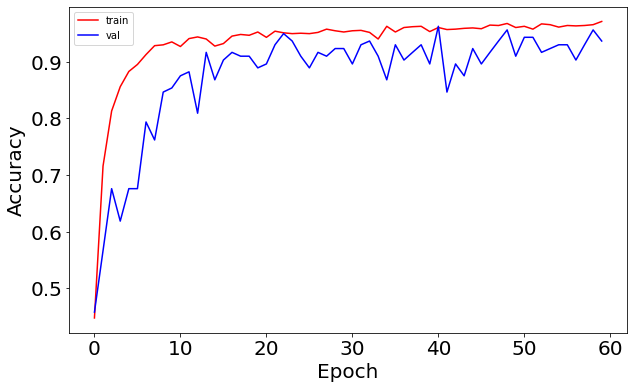

========== dropout [ 0.0 ][ 2 ]===========


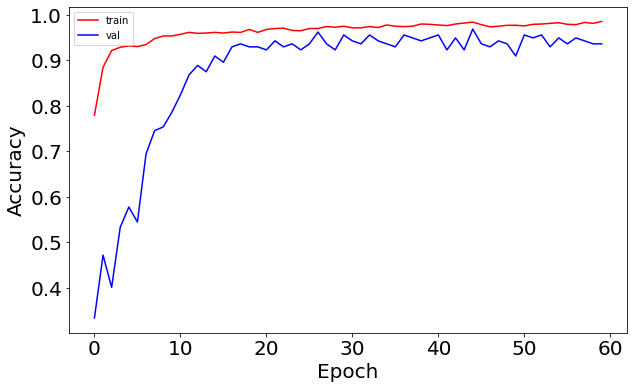

========== dropout [ 0.0 ][ 3 ]===========


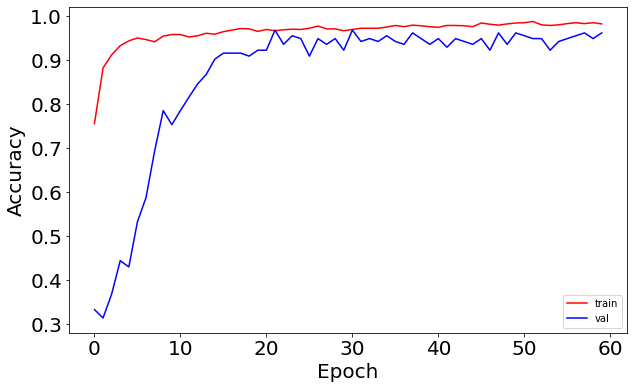

========== dropout [ 0.0 ][ 4 ]===========


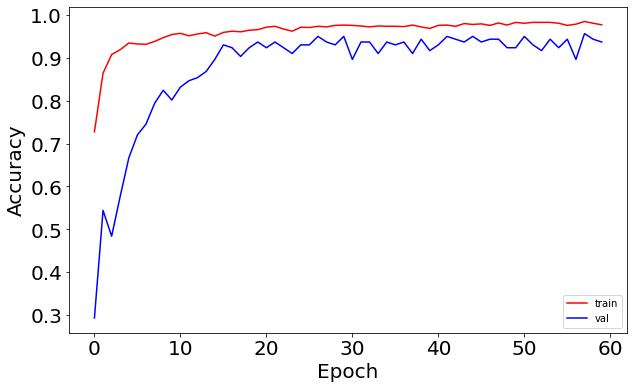

========== dropout [ 0.0 ][ 5 ]===========


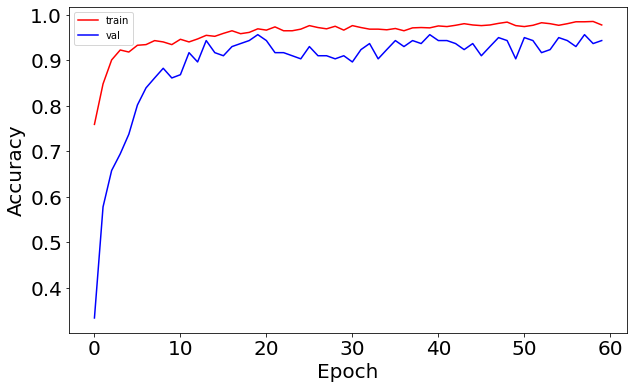

========== dropout [ 0.1 ][ 1 ]===========


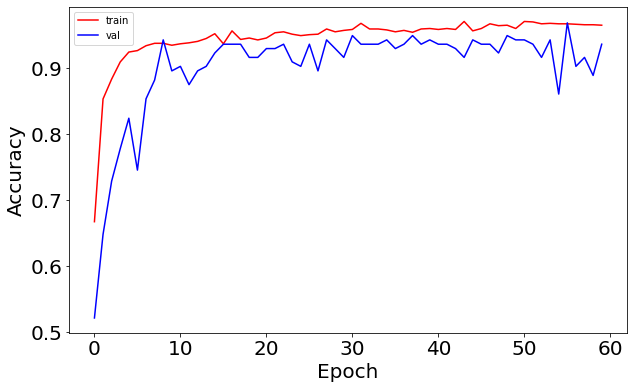

========== dropout [ 0.1 ][ 2 ]===========


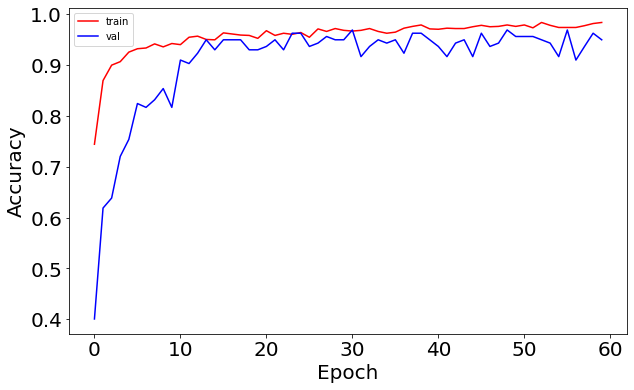

========== dropout [ 0.1 ][ 3 ]===========


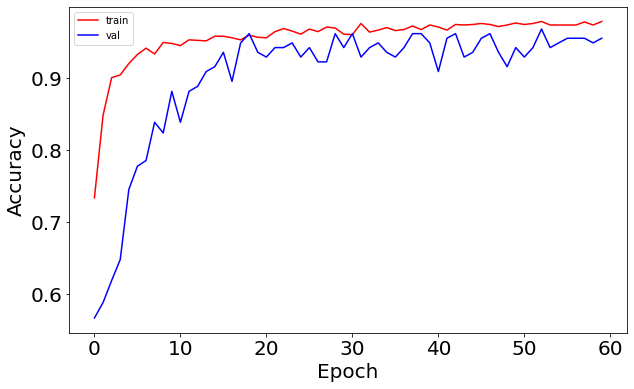

========== dropout [ 0.1 ][ 4 ]===========


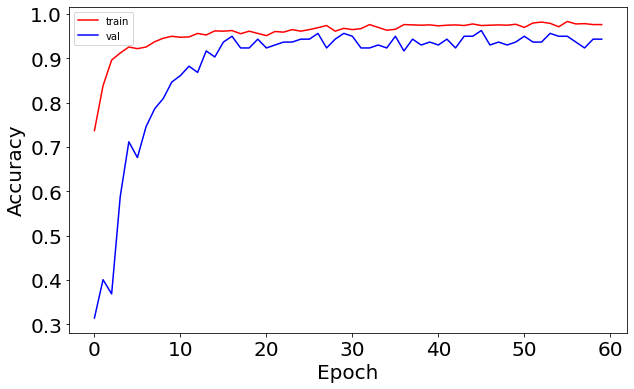

========== dropout [ 0.1 ][ 5 ]===========


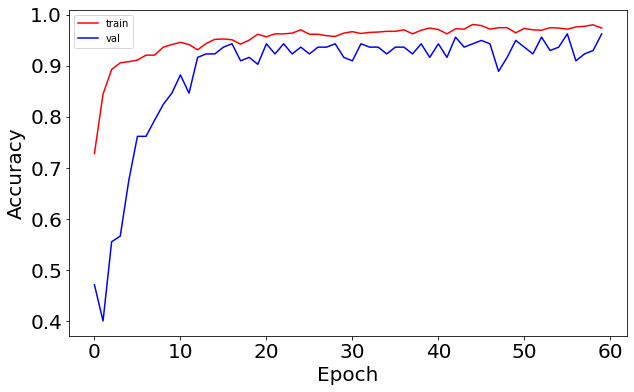

========== dropout [ 0.2 ][ 1 ]===========


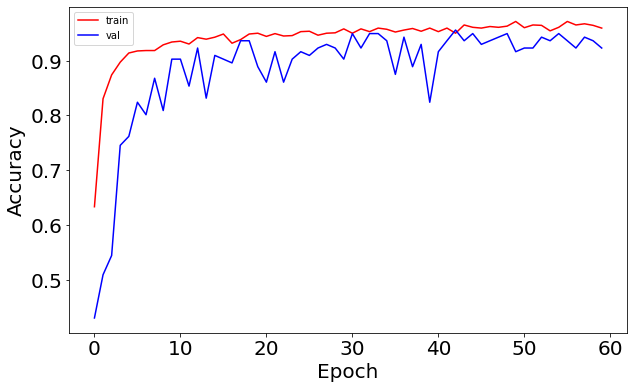

========== dropout [ 0.2 ][ 2 ]===========


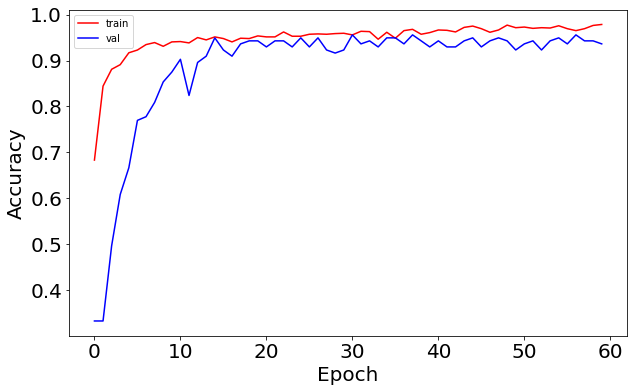

========== dropout [ 0.2 ][ 3 ]===========


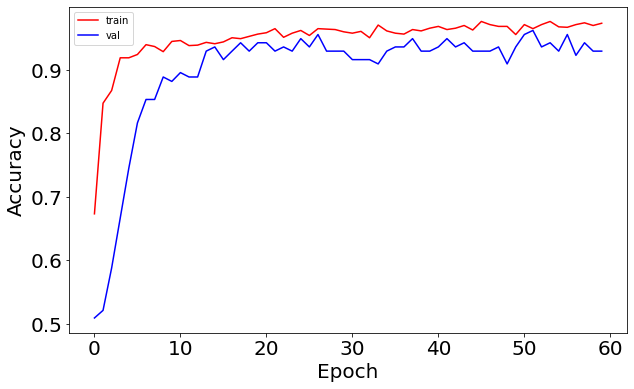

========== dropout [ 0.2 ][ 4 ]===========


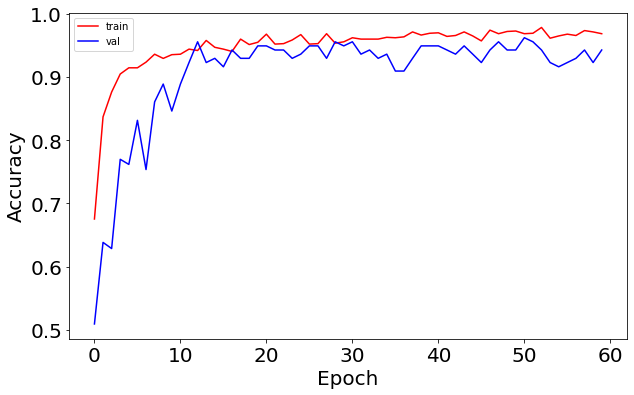

========== dropout [ 0.2 ][ 5 ]===========


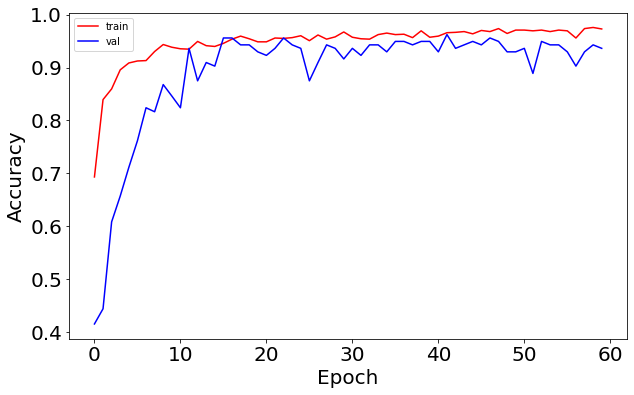

========== dropout [ 0.3 ][ 1 ]===========


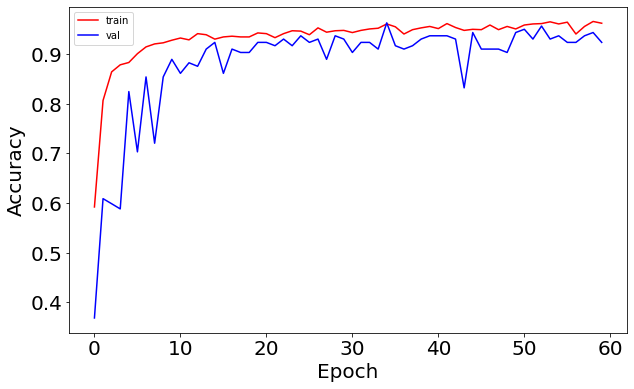

========== dropout [ 0.3 ][ 2 ]===========


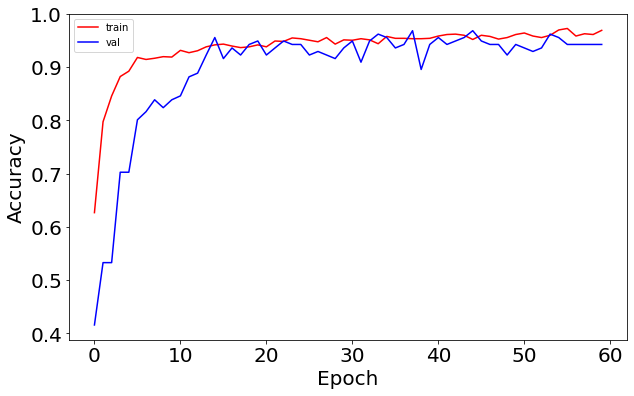

========== dropout [ 0.3 ][ 3 ]===========


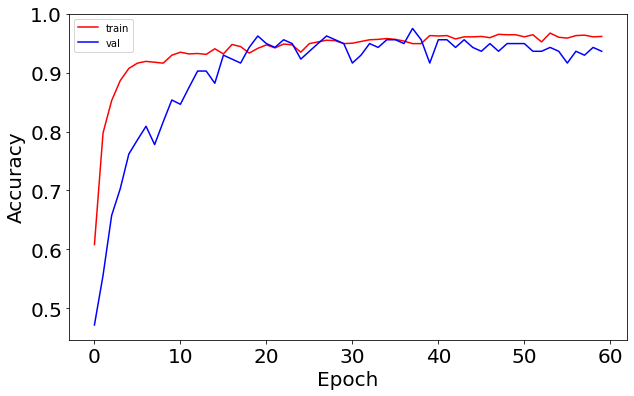

========== dropout [ 0.3 ][ 4 ]===========


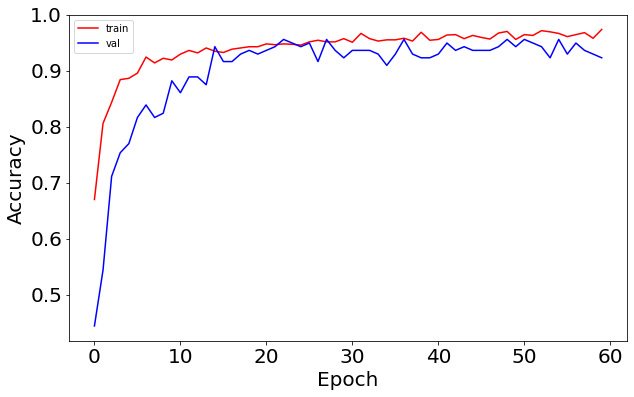

========== dropout [ 0.3 ][ 5 ]===========


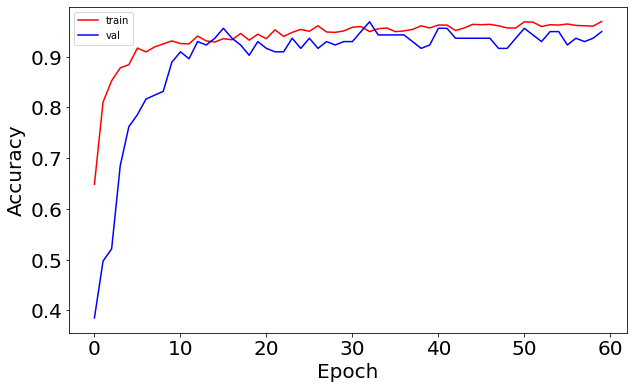

========== dropout [ 0.4 ][ 1 ]===========


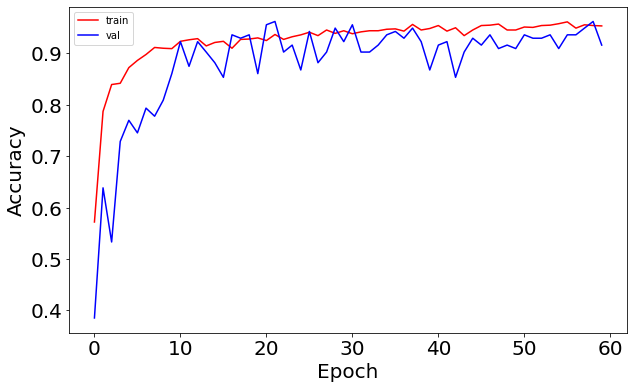

========== dropout [ 0.4 ][ 2 ]===========


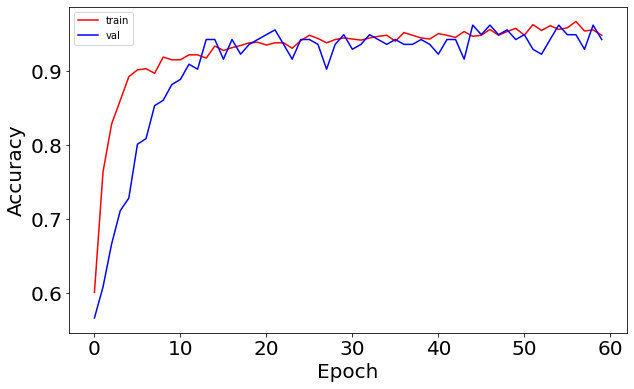

========== dropout [ 0.4 ][ 3 ]===========


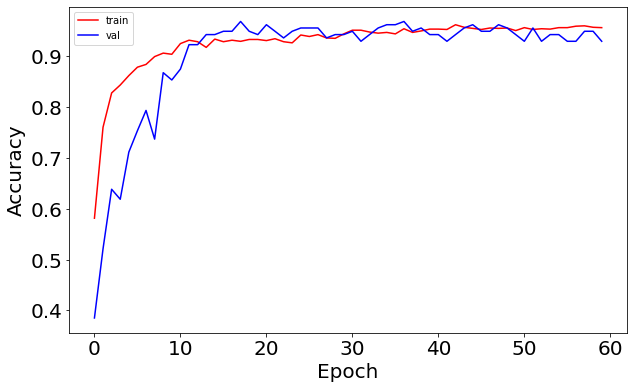

========== dropout [ 0.4 ][ 4 ]===========


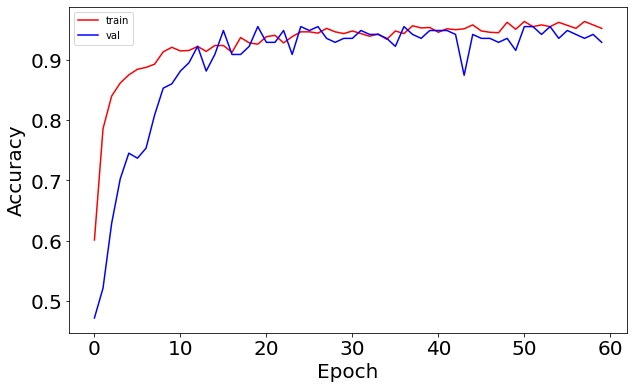

========== dropout [ 0.4 ][ 5 ]===========


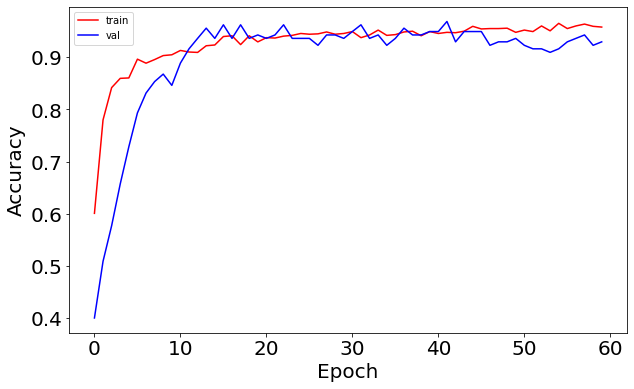

========== dropout [ 0.5 ][ 1 ]===========


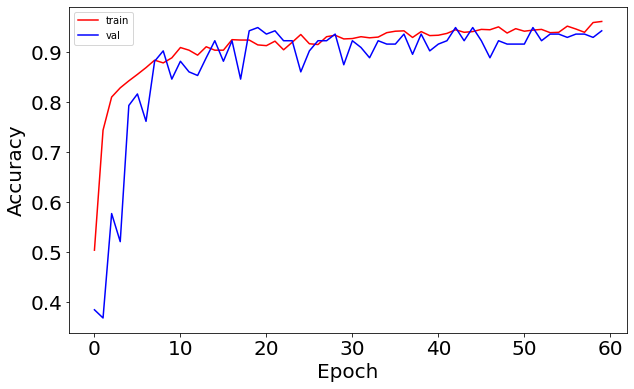

========== dropout [ 0.5 ][ 2 ]===========


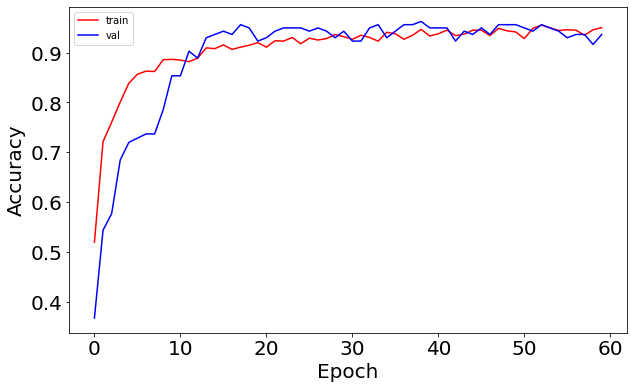

========== dropout [ 0.5 ][ 3 ]===========


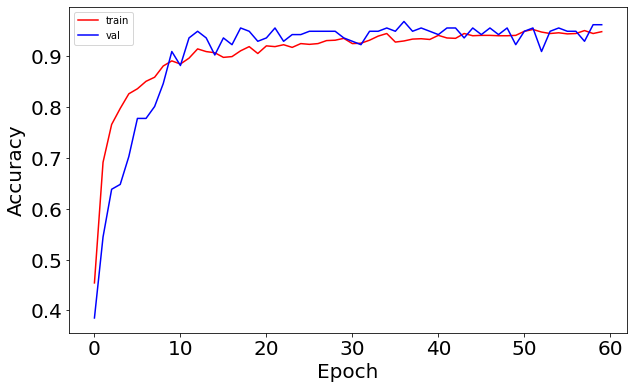

========== dropout [ 0.5 ][ 4 ]===========


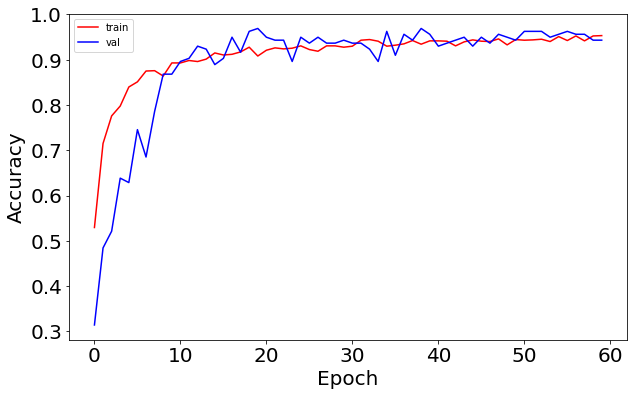

========== dropout [ 0.5 ][ 5 ]===========


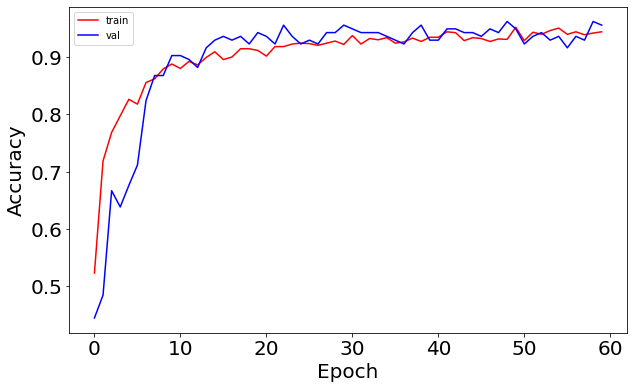

========== dropout [ 0.6 ][ 1 ]===========


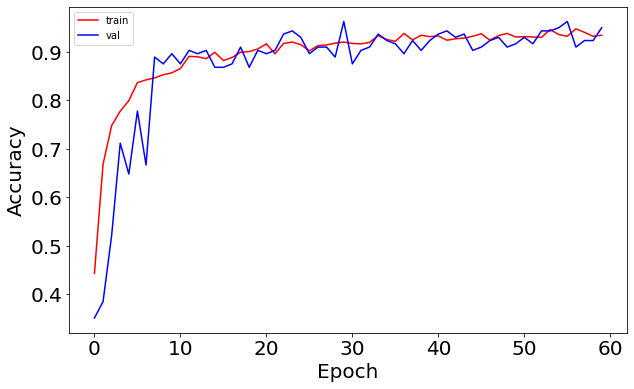

========== dropout [ 0.6 ][ 2 ]===========


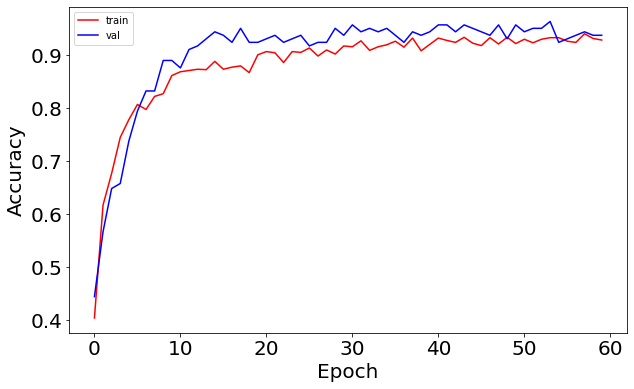

========== dropout [ 0.6 ][ 3 ]===========


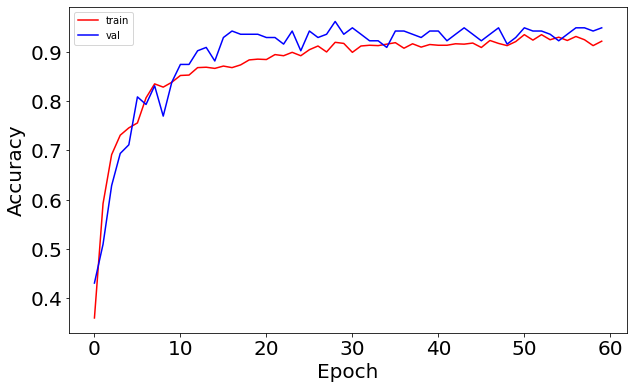

========== dropout [ 0.6 ][ 4 ]===========


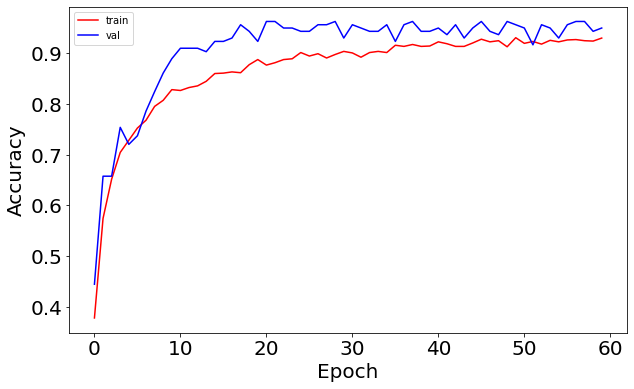

========== dropout [ 0.6 ][ 5 ]===========


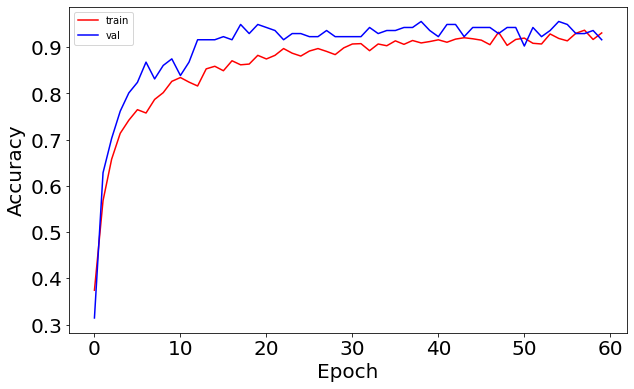

========== dropout [ 0.7 ][ 1 ]===========


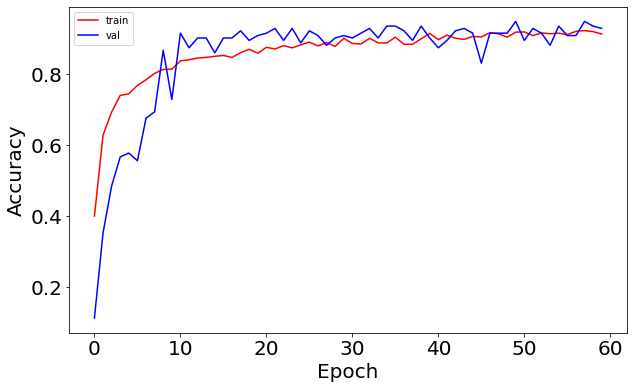

========== dropout [ 0.7 ][ 2 ]===========


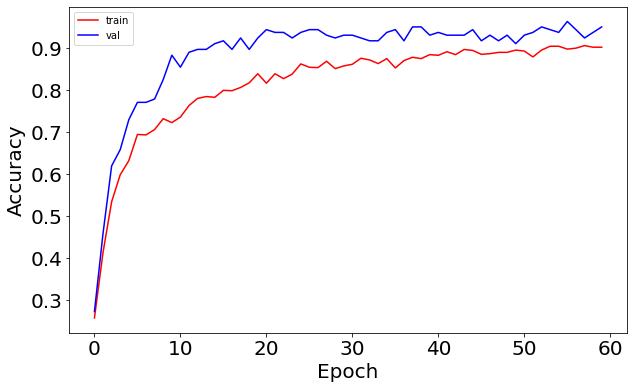

========== dropout [ 0.7 ][ 3 ]===========


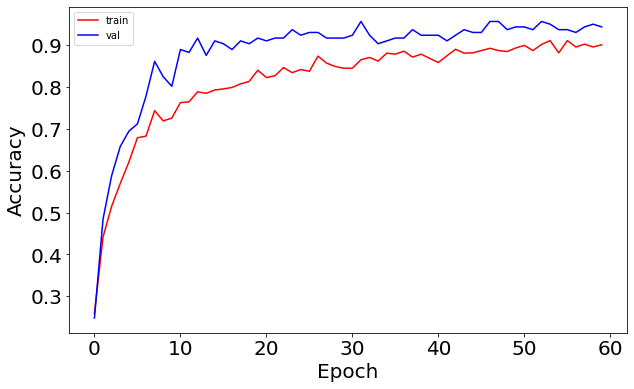

========== dropout [ 0.7 ][ 4 ]===========


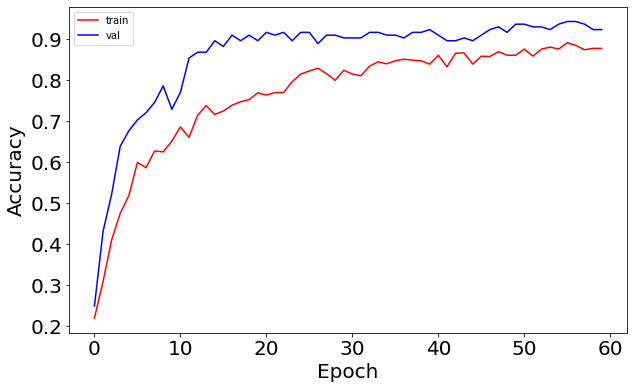

========== dropout [ 0.7 ][ 5 ]===========


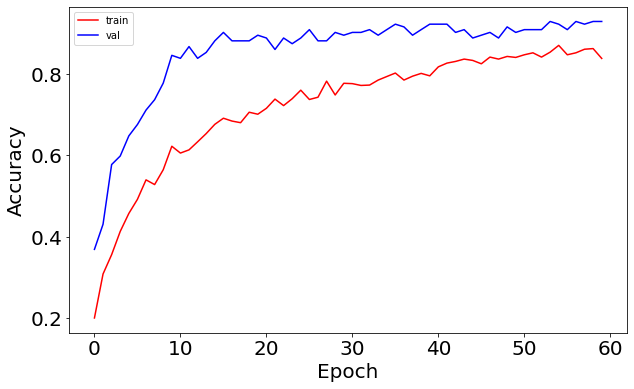

========== dropout [ 0.8 ][ 1 ]===========


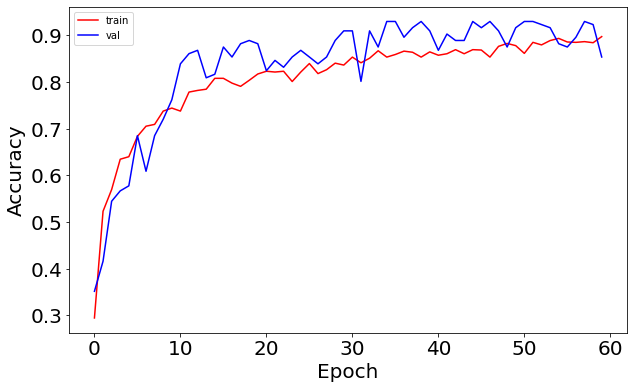

========== dropout [ 0.8 ][ 2 ]===========


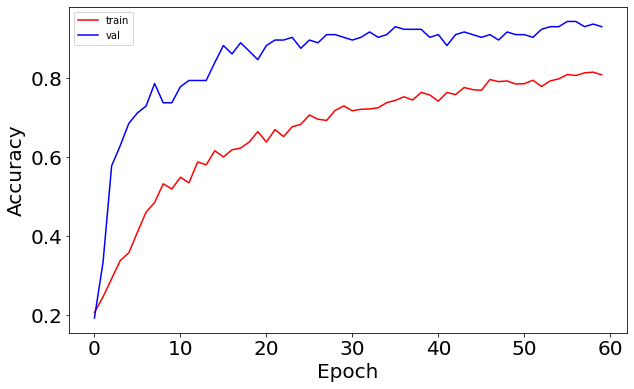

========== dropout [ 0.8 ][ 3 ]===========


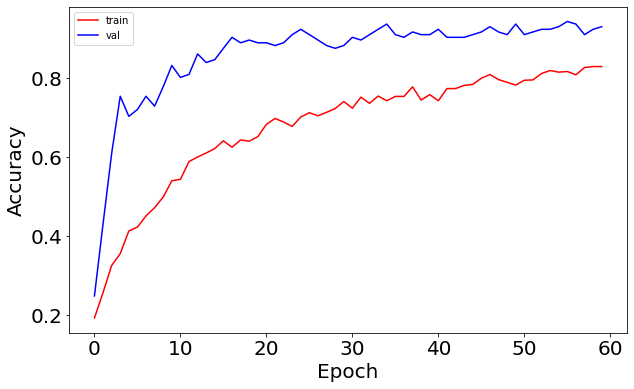

========== dropout [ 0.8 ][ 4 ]===========


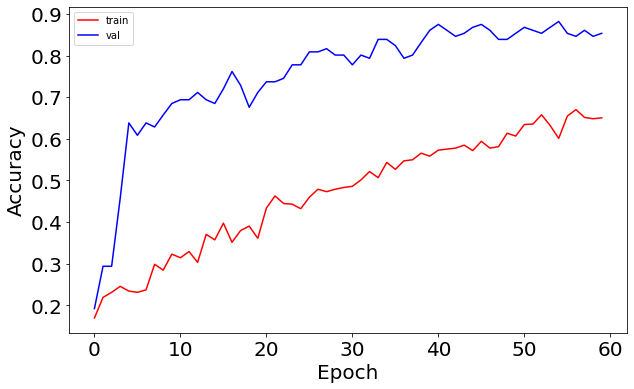

========== dropout [ 0.8 ][ 5 ]===========


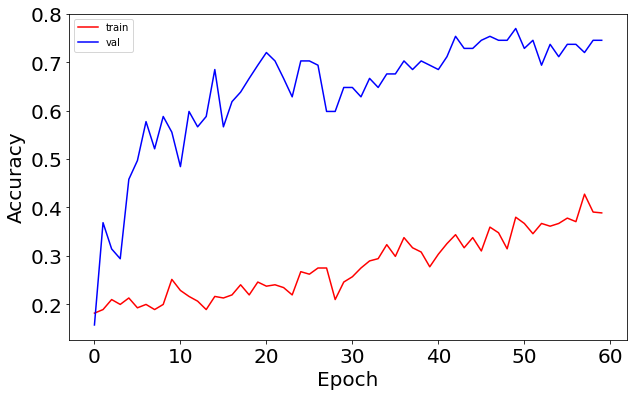

========== dropout [ 0.9 ][ 1 ]===========


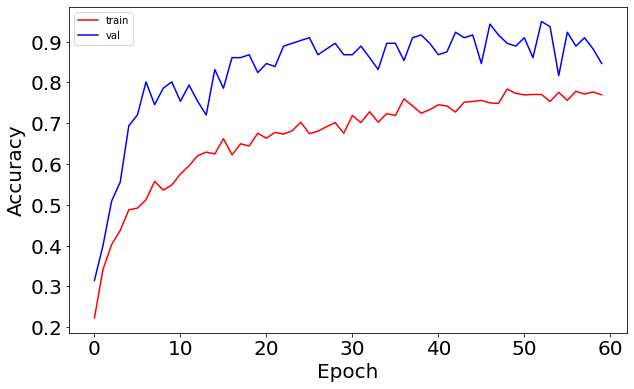

========== dropout [ 0.9 ][ 2 ]===========


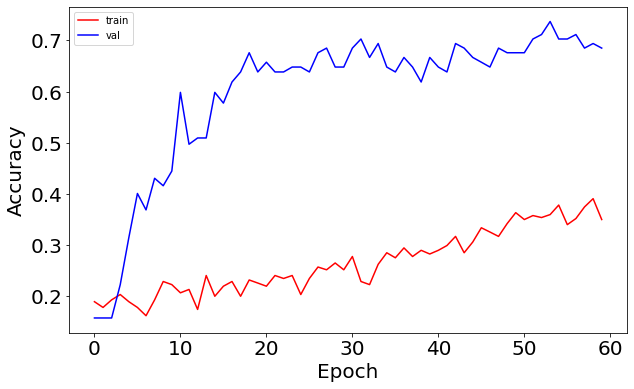

========== dropout [ 0.9 ][ 3 ]===========


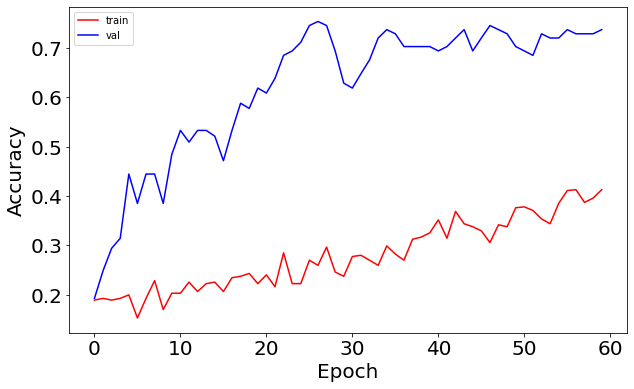

========== dropout [ 0.9 ][ 4 ]===========


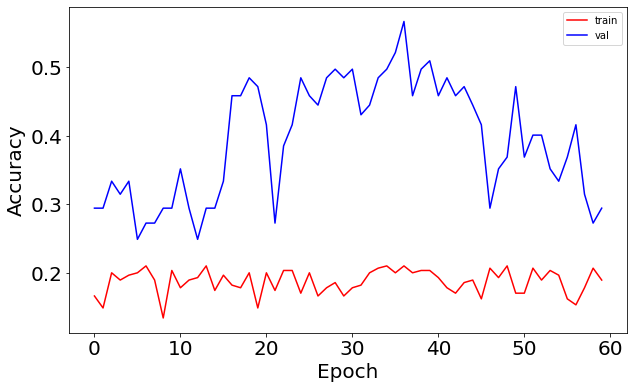

========== dropout [ 0.9 ][ 5 ]===========


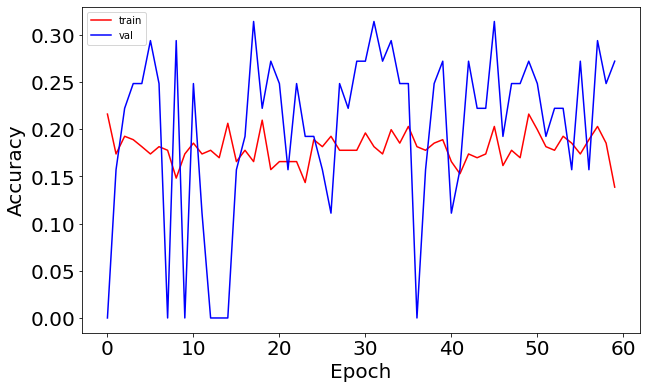

In [49]:
dropout_rate = 0.0
layer = 1
for g in gestures:
  if layer == 6:
    layer = 1
    dropout_rate += 0.1
  print("========== dropout [", round(dropout_rate,1) , "][", layer,"]===========")
  # plot_loss(g)
  plot_accurancy(g)
  layer += 1